# CM3015 Final report
#### Kenjiro Ono
#### Student number : 170380405
#### 27 March 2022

## Introduction:
- In this report, a multi-class, single-image classification problem is expolored using <b>German Traffic Sign Recognition Benchmark(GTSRB)</b> dataset [1].
- The dataset contains 26640 annnotated traffic sign images each belonging to one of 43 classes. The images are labeled with a corresponding class.
- The GTSRB dataset is used at the multi-class, single-image classificaiton challenge held at the <b>International Joint Conference on Neural Networks (IJCNN) 2011 [1]</b>.

##  Hypothesis:
- Given an image containing a traffic sign, the model should return the prediction of the traffic sign belonging to one of the 43 traffic sign classes.
- The amount of data is sufficient to learn about the relationship between inputs and outputs.

## Evaluation metric:
- <b>Accuracy:</b> The applicaiton of this classification model may be deployed in a  self-driving car system detecting the traffic signs.  A failure to correctly classifying the traffic sign may cause a great hazard, therefore the accuracy is crucial for the prediction model.
- <b>Last-layer activation (softmax):</b> The network outputs a probability distribution across classes. 
- <b>Sparse Categorical Cross-Entropy Loss:</b> is used for the loss function, which is used for two or more label classes and takes an input label as an integer instead of one-hot encoding. The model output would be a probability distribution over 43 calsses for each input image and the most probable class is returned as a predicted class. 
- <b>Optimizer :</b> As a default optimizer, rmsprop with the learning rate of  0.001 is used.

## Model and Hyper-parameter tuning:

### Convolutional Nueral Network Model:
- In this report, Convolutional Neural Network model is used. 
- In Convolutional Neural Networks, a <b>convolutional layer</b> extracts the important features from the input image by applying <b>convolution filters</b> to produce a <b>feature map</b>. After convolution operations, a feature map is fed into a <b>pooling layer</b> to reduce the dimensionality while keeping the most important feature representation. This would reduce the number of parameters and help prevent overfitting. The reduction of parameters also improves the <b>computational efficiency</b>.
- <b>Lenet-5 Convolutional Neural Network architecture [2]</b> was designed for hand-written digit classification problem. A lenet-5 CNN inspired architecture is used. 

### Hyperparameters:
- <b>Learning rate:</b> The learning rate of the optimizer is adjusted. 
- <b>Dropout:</b> different dropout rates are experimented [3].
- <b>Model Capacity:</b> model capacity is adjusted to optimize generalization of the model.
- <b>Weight regularization:</b> Penalizes the large weight value of the model to mitigate overfitting and encourages the model to be generalizable.

### Validation method:
 - <b>Hold-out validation:</b> The dataset contains 26640 samples, which is a large amount of data, therefore hold-out validation is used with the ratio of 8:2, a training and a test dataset respectively

## Data preparation:

- <b>Image representation:</b>
 - Before:
     - Image sizes vary between 15x15 and 250x250 pixels.
     - A pixel value range between 0~255.
     - Not all images are squared.
     - Traffic sign is not centered within the image.
     - Image contains 10% border pixels around the traffic sign within the image.
 - After:
     - All images are resized to the same dimensions and squared.
     - Each pixel value is normalized to a range between 0~1.
     - Resizing would preserve the 10% border pixels around the traffic sign within the image.

- <b>Validation split:</b> Both train and validation datasets should have a proportional class distribution.
- <b>Test dataset:</b> separate test dataset consists of 12630 images are used as a final test set.


In [1]:
# Import dependencies:
import os
import glob
import random
import csv
import statistics
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import datetime
from tensorflow.keras.preprocessing import image_dataset_from_directory
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Data preparation settings
validation_split = 0.2
image_size = (32, 32)
batch_size = 32
seed = 10

In [3]:
def normalize(image,label):
    """ normalize input images """
    image = tf.cast(image/255. ,tf.float32)
    return image,label

def get_dataset(dir_path):
    """ 
        Load iamge and label data from the directry
        return: Normalized train and validation datasets
    """
    train_dataset = tf.keras.utils.image_dataset_from_directory(
                        dir_path,
                        validation_split = validation_split,
                        subset = "training",
                        seed = seed,
                        image_size = image_size,
                        batch_size = batch_size,
                        label_mode='int'
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
                        dir_path,
                        validation_split = validation_split,
                        subset = "validation",
                        seed = seed,
                        image_size = image_size,
                        batch_size = batch_size,
                        label_mode='int'
    )
    train_dataset = train_dataset.map(normalize)
    validation_dataset = validation_dataset.map(normalize)
    return train_dataset, validation_dataset

In [4]:
# Create train and validation datasets
train_dataset, validation_dataset = get_dataset('GTSRB/Training')

Found 26640 files belonging to 43 classes.
Using 21312 files for training.
Found 26640 files belonging to 43 classes.
Using 5328 files for validation.


In [5]:
def get_test_dataset(rootpath):
    """
        Arguments: dirpath
        Returns:   list of images, list of corresponding labels
    """
    test_images = [] # images
    labels = [] # corresponding labels
    prefix = rootpath
    gtFile = open(prefix + 'GT-final_test.csv') # GT file
    gtReader = csv.reader(gtFile, delimiter=',') # csv parser for annotations file
    next(gtReader) # skip header
    # loop over all images in current annotations file
    for row in gtReader:
        test_images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
        labels.append(int(row[7])) # the 8th column is the label
    gtFile.close()
    
    # convert to tf tensor
    test_images = [tf.convert_to_tensor(im, dtype=tf.float32) for im in test_images] 
    # resize
    test_images = [tf.image.resize(im, image_size) for im in test_images] 
    # normalise
    test_images = [tf.cast(im/255., tf.float32) for im in test_images]
    # add dimension
    test_images = [tf.expand_dims(im, axis=0) for im in test_images]
    # convert to tf tensor
    test_labels = [tf.convert_to_tensor(i, dtype=tf.int32) for i in labels]
    return test_images, test_labels

In [6]:
test_images, test_labels = get_test_dataset('GTSRB/Final_Test/Images/')

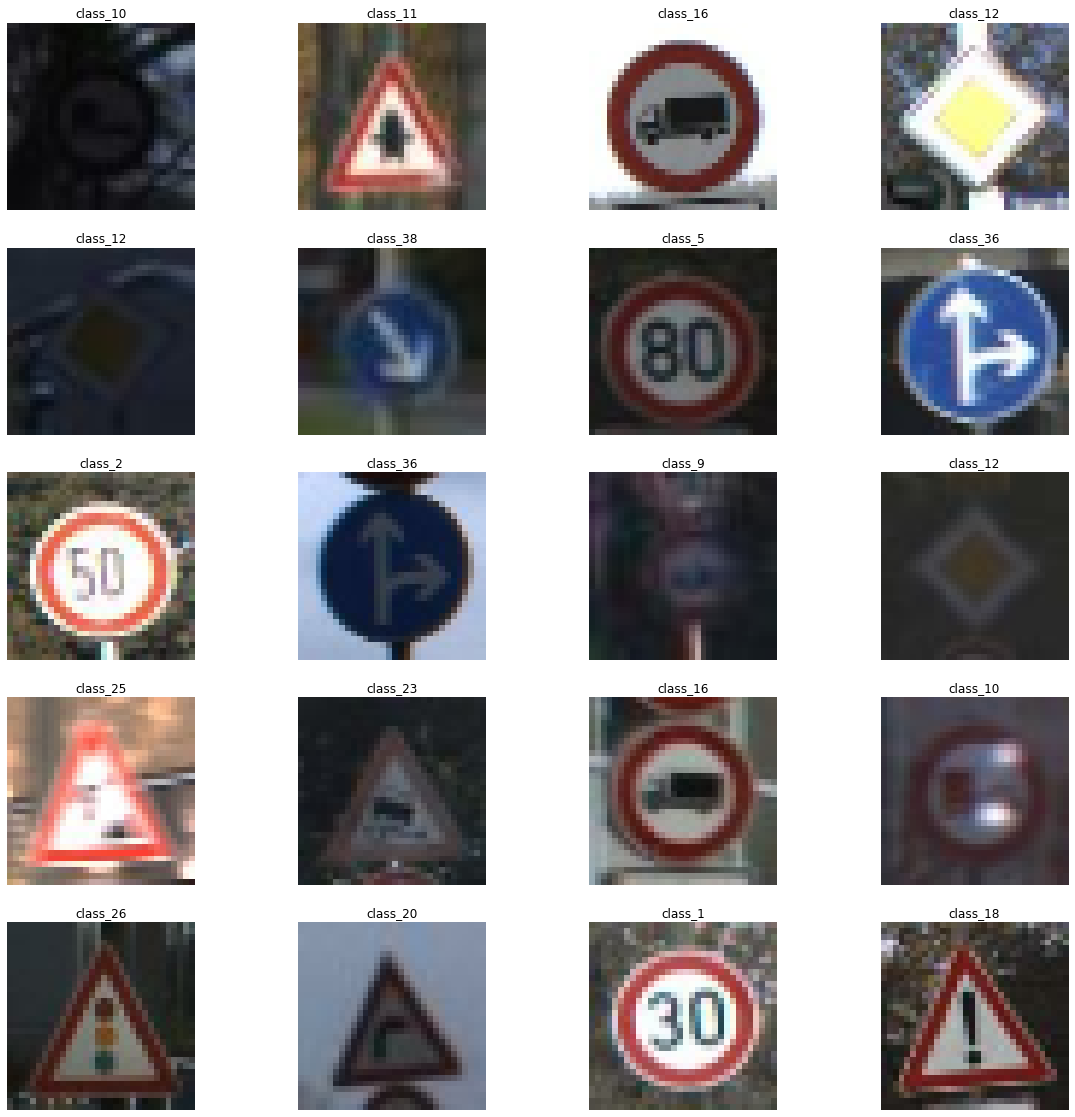

In [7]:
# Resized image preview
plt.figure(figsize = (20, 20))
for images, labels in train_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i])        
        plt.title(str(f'class_{int(labels[i])}'))
        plt.axis("off")

In [8]:
def get_labels(dataset):
    """ Extract labels from the dataset """
    labels = []
    for data, label in dataset:
        labels.append(label.numpy())
    labels = np.concatenate(labels)
    return labels

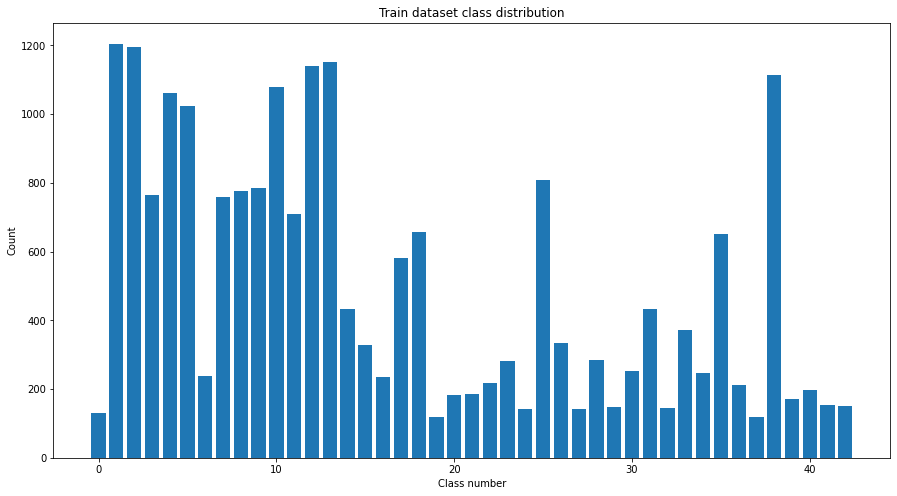

Max = 1205
Min = 118            
Mean = 495.63
Stdev = 366.72


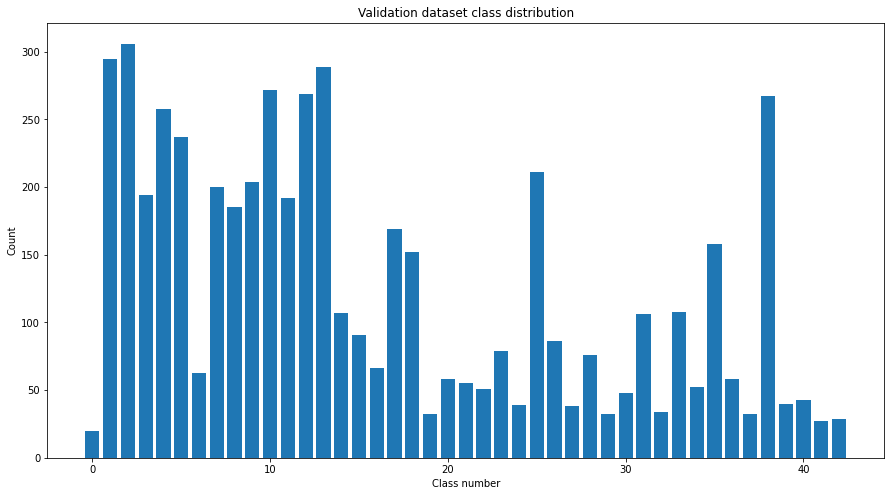

Max = 306
Min = 20            
Mean = 123.91
Stdev = 91.02


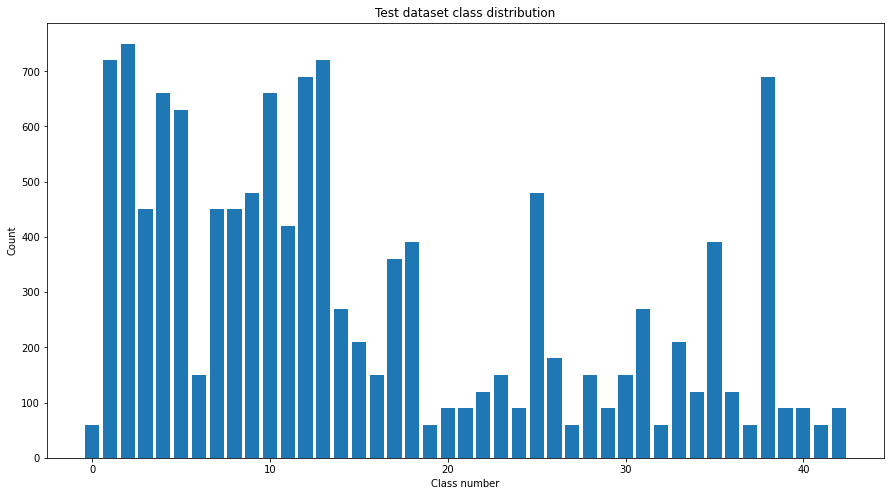

Max = 750
Min = 60            
Mean = 293.72
Stdev = 230.71


In [9]:
def show_class_dist(labels, name):
    """ Display class distribution of a dataset """
    # count classes
    classes = np.max(labels) + 1
    class_counts = np.zeros(classes)
    for label in labels:
        class_counts[label] += 1

    # Class distribution graph
    fig, ax = plt.subplots(figsize=(15,8))
    ax.bar(np.arange(0,classes),class_counts)
    ax.set_title(f'{name} dataset class distribution')
    ax.set_ylabel('Count')
    ax.set_xlabel('Class number')
    plt.show() 
    
    # standard deviation
    max_count, min_count = int(np.max(class_counts)), int(np.min(class_counts))
    mu = np.mean(class_counts)
    sigma = np.std(class_counts)
    print(f'Max = {max_count}\nMin = {min_count}\
            \nMean = {round(mu, 2)}\nStdev = {round(sigma, 2)}')

    
train_labels = get_labels(train_dataset)
validation_labels = get_labels(validation_dataset)

show_class_dist(train_labels, 'Train')
show_class_dist(validation_labels, 'Validation')
show_class_dist(test_labels, 'Test')

The number of samples each class varies significantly. The most represented class has samples more than ten times than the least represented class. However, the class representations are proprtional across train, validation and test dataset. This might pose a model performance issue on less represented classes. 

In [10]:
# Display losses and accuracies for training and validaiton process
def display_metrics(history):
    """ plot loss and accuracy from keras history object """
    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history.history['loss'], linewidth=3)
    ax[0].plot(history.history['val_loss'], linewidth=3) 
    ax[0].set_title('Loss', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)
    ax[0].legend(['train loss', 'val loss'], loc='upper right')
    ax[1].plot(history.history['accuracy'], linewidth=3)
    ax[1].plot(history.history['val_accuracy'], linewidth=3)
    ax[1].set_title('Accuracy', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)
    ax[1].legend(['train acc', 'val acc'], loc='upper left')
    plt.show()
    
    print(f'Max validation accuracy={round(np.max(history.history["val_accuracy"]),3)}'+
             (f' at epoch={np.argmax(history.history["val_accuracy"])}'))
    print(f'Min validation loss={round(np.min(history.history["val_loss"]),3)}' + 
                        (f' at epoch={np.argmin(history.history["val_loss"])}'))

In [11]:
def predict(model, test_images):
    """ 
        test_images: 4-dimensions(1, [resized dimension], 3)
        y_: prediction(probability distribution)
    """
    y_ = []
    for i in range(len(test_images)):
        y_.append(model(test_images[i]))
        
    return y_


def confusion_matrix(y_, test_labels):
    """ return confusion matrix (43x43)"""
    class_num = np.max(test_labels)+1
    conf_matrix = np.zeros((class_num, class_num), dtype=int)
    for i in range(len(test_labels)):
        gt = int(test_labels[i])
        pred = np.argmax(y_[i])
        conf_matrix[gt][pred] += 1
        
    return conf_matrix


def class_recall(conf_matrix):
    """ return (TP / TP + FN) """
    class_num = len(conf_matrix[0])
    class_recall = np.zeros(class_num)
    for i in range(class_num):
        class_total = np.sum(conf_matrix[i])        
        class_recall[i] = conf_matrix[i][i] / class_total # TP / TP+FN
    
    return class_recall


def class_precision(conf_matrix):
    """ return (TP / TP + FP) """
    class_num = len(conf_matrix[0])
    conf_sum = np.sum(conf_matrix, axis=0)
    class_prec = np.zeros(class_num)
    for i in range(class_num):
        if conf_sum[i] != 0:
            class_prec[i] = conf_matrix[i][i] / conf_sum[i] # TP / TP+FP
        else:
            class_prec[i] = 0
        
    return class_prec


def total_accuaracy(conf_matrix):
    """ return total accuracy """
    total_sum = np.sum(conf_matrix)
    TP_sum = 0
    for i in range(len(conf_matrix[0])):
        TP_sum += conf_matrix[i][i]
            
    return TP_sum / total_sum

In [12]:
# evaluate final model
def evaluate_model(model, test_images, test_labels):
    """ 
        Evaluate model with the test dataset and display recall and precision for 
        each class.
        return: accuracy, class recalls, class precision
    """
    y_ = predict(model, test_images)
    conf_mat = confusion_matrix(y_, test_labels)
    total_acc = total_accuaracy(conf_mat)
    class_rec = class_recall(conf_mat)
    class_prec = class_precision(conf_mat)
    
    # plot class recall and precision
    classes = np.arange(0,43)
    w = 0.35
    fig, ax = plt.subplots(figsize=(15,8))
    rect_1 = ax.bar(classes - w/2 , class_rec, width=w, label='Recall')
    rect_2 = ax.bar(classes + w/2, class_prec, width=w, label='Precision')
    ax.set_title(f'Class Recall / Precision')
    ax.set_ylabel('%')
    ax.set_xlabel('Class number')
    ax.set_xticks(classes)
    ax.legend()
    fig.tight_layout()
    plt.show() 
    print(f'Total accuracy = {round(total_acc, 3)}')    
    
    return total_acc, class_rec, class_prec

## Baseline CNN model:
The baseline CNN model shall have a statisical power that is the model should archieve an accuracy higher than $\frac{1}\{Classes}\   = \frac{1}\{43}\ = 0.023\$

In [13]:
# Minimal Convolutional Nueral Network architecture
def baseline_CNN():
    model = tf.keras.models.Sequential()
    # Convolutional layer
    model.add(tf.keras.layers.Conv2D(1, 5, 1, activation='relu'))
    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(43))
    return model

Epoch 1/3
666/666 [==============================] - 3s 3ms/step - loss: 1.6658 - accuracy: 0.5920 - val_loss: 0.9742 - val_accuracy: 0.7301
Epoch 2/3
666/666 [==============================] - 2s 3ms/step - loss: 0.7096 - accuracy: 0.8257 - val_loss: 0.6663 - val_accuracy: 0.8316
Epoch 3/3
666/666 [==============================] - 2s 3ms/step - loss: 0.5367 - accuracy: 0.8684 - val_loss: 0.5627 - val_accuracy: 0.8622
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 1)         76        
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 43)                33755     
                                                                 
Total params: 33,831
Trainabl

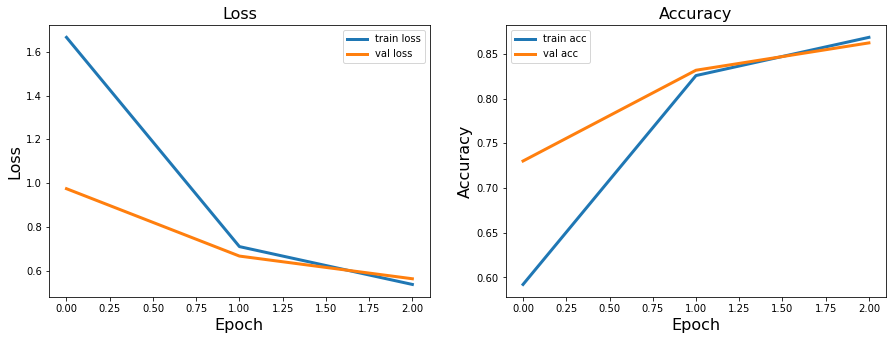

Max validation accuracy=0.862 at epoch=2
Min validation loss=0.563 at epoch=2


In [14]:
baseline_CNN = baseline_CNN()
baseline_CNN.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
history = baseline_CNN.fit(x=train_dataset,  
                    epochs=3, 
                    validation_data=validation_dataset)
print(baseline_CNN.summary())
display_metrics(history)

The baseline CNN model is said to have statistical power, however, the model is likely to  perform significantly poorer for the classes with smaller data representations in the datasets.   

## Overfitting CNN Model:
The number of epochs are increased to overfit the model

In [15]:
# Lenet-5 inspired Convolutional Nueral Network architecture
def overfit_CNN():
    model = tf.keras.models.Sequential()
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dense(84, activation='relu'))
    model.add(tf.keras.layers.Dense(43))
    return model

Epoch 1/100
666/666 [==============================] - 3s 4ms/step - loss: 2.0377 - accuracy: 0.4673 - val_loss: 1.0762 - val_accuracy: 0.6984
Epoch 2/100
666/666 [==============================] - 3s 4ms/step - loss: 0.8051 - accuracy: 0.7710 - val_loss: 0.6219 - val_accuracy: 0.8320
Epoch 3/100
666/666 [==============================] - 3s 4ms/step - loss: 0.5111 - accuracy: 0.8542 - val_loss: 0.4750 - val_accuracy: 0.8776
Epoch 4/100
666/666 [==============================] - 3s 4ms/step - loss: 0.3784 - accuracy: 0.8927 - val_loss: 0.3767 - val_accuracy: 0.8994
Epoch 5/100
666/666 [==============================] - 3s 4ms/step - loss: 0.3061 - accuracy: 0.9141 - val_loss: 0.4005 - val_accuracy: 0.8940
Epoch 6/100
666/666 [==============================] - 3s 4ms/step - loss: 0.2542 - accuracy: 0.9298 - val_loss: 0.2819 - val_accuracy: 0.9259
Epoch 7/100
666/666 [==============================] - 3s 4ms/step - loss: 0.2166 - accuracy: 0.9410 - val_loss: 0.2586 - val_accuracy: 0.9384

Epoch 58/100
666/666 [==============================] - 2s 3ms/step - loss: 0.0282 - accuracy: 0.9933 - val_loss: 0.4301 - val_accuracy: 0.9651
Epoch 59/100
666/666 [==============================] - 2s 3ms/step - loss: 0.0252 - accuracy: 0.9943 - val_loss: 0.4368 - val_accuracy: 0.9694
Epoch 60/100
666/666 [==============================] - 2s 3ms/step - loss: 0.0255 - accuracy: 0.9942 - val_loss: 0.4779 - val_accuracy: 0.9655
Epoch 61/100
666/666 [==============================] - 2s 3ms/step - loss: 0.0253 - accuracy: 0.9944 - val_loss: 0.4593 - val_accuracy: 0.9660
Epoch 62/100
666/666 [==============================] - 2s 3ms/step - loss: 0.0265 - accuracy: 0.9938 - val_loss: 0.4878 - val_accuracy: 0.9645
Epoch 63/100
666/666 [==============================] - 3s 4ms/step - loss: 0.0261 - accuracy: 0.9945 - val_loss: 0.5343 - val_accuracy: 0.9621
Epoch 64/100
666/666 [==============================] - 3s 4ms/step - loss: 0.0212 - accuracy: 0.9952 - val_loss: 0.4603 - val_accuracy:

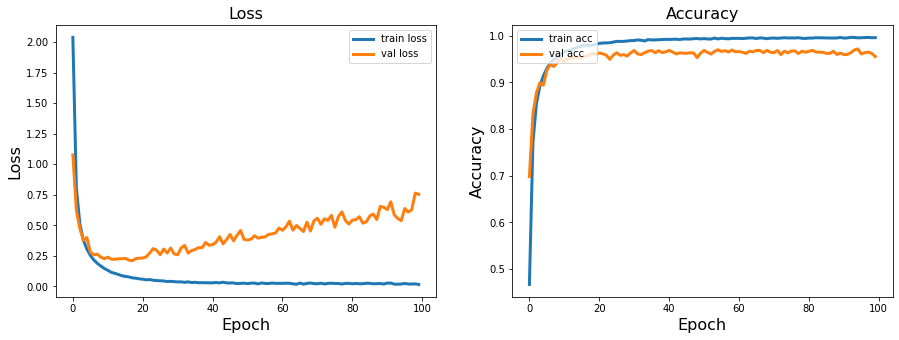

Max validation accuracy=0.972 at epoch=94
Min validation loss=0.21 at epoch=17


In [16]:
overfit_CNN = overfit_CNN()
overfit_CNN.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
history = overfit_CNN.fit(x=train_dataset,  
                    epochs=100, 
                    validation_data=validation_dataset)
print(overfit_CNN.summary())
display_metrics(history)

- The training loss decreases smoothly over the epochs, however the validation loss moves noisily around the training loss. This might be the case that the trainable parameters are disproportionately larger compared to the validation dataset, therefore, network parameters are not adjusted effectively after each epoch.
- From the result, around 17 epochs are sufficient to train the model.

In [17]:
# Lenet-5 inspired Convolutional Nueral Network architecture
def lenet_5_CNN():
    model = tf.keras.models.Sequential()
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dense(84, activation='relu'))
    model.add(tf.keras.layers.Dense(43))
    return model

Epoch 1/17
666/666 [==============================] - 4s 5ms/step - loss: 2.4115 - accuracy: 0.3610 - val_loss: 1.5509 - val_accuracy: 0.5559
Epoch 2/17
666/666 [==============================] - 2s 4ms/step - loss: 1.1332 - accuracy: 0.6717 - val_loss: 0.8704 - val_accuracy: 0.7566
Epoch 3/17
666/666 [==============================] - 2s 4ms/step - loss: 0.7141 - accuracy: 0.7943 - val_loss: 0.6810 - val_accuracy: 0.8136
Epoch 4/17
666/666 [==============================] - 2s 4ms/step - loss: 0.5183 - accuracy: 0.8500 - val_loss: 0.5956 - val_accuracy: 0.8346
Epoch 5/17
666/666 [==============================] - 3s 4ms/step - loss: 0.3982 - accuracy: 0.8871 - val_loss: 0.4043 - val_accuracy: 0.8902
Epoch 6/17
666/666 [==============================] - 2s 4ms/step - loss: 0.3199 - accuracy: 0.9093 - val_loss: 0.3532 - val_accuracy: 0.9080
Epoch 7/17
666/666 [==============================] - 2s 4ms/step - loss: 0.2697 - accuracy: 0.9259 - val_loss: 0.3418 - val_accuracy: 0.9135
Epoch 

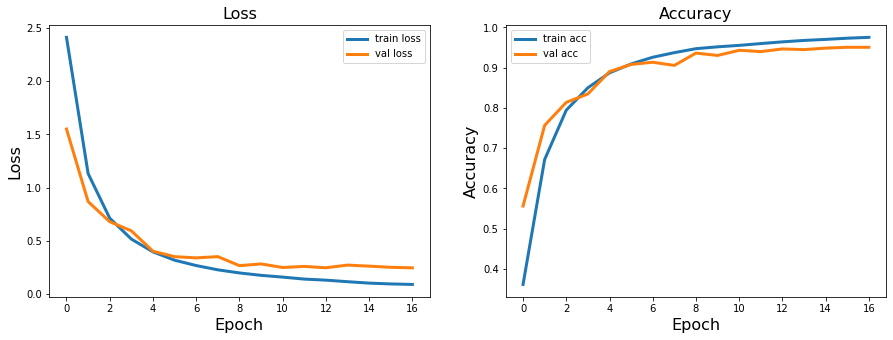

Max validation accuracy=0.951 at epoch=15
Min validation loss=0.248 at epoch=16


In [18]:
lenet_5_CNN = lenet_5_CNN()
lenet_5_CNN.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
history = lenet_5_CNN.fit(x=train_dataset,  
                    epochs=17, 
                    validation_data=validation_dataset)
print(lenet_5_CNN.summary())
display_metrics(history)

## Regularising and Hyperparameter tuning:  
The hyper parameter values for different settings are explored iteratively.

## Learning Rate:
- Different learning rates are used and the results are compared.
- The learning rates are arranged between 0.0001~0.003 with 0.0002 increments.

In [24]:
# Lenet-5 inspired Convolutional Nueral Network architecture
def lr_CNN():
    model = tf.keras.models.Sequential()
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dense(84, activation='relu'))
    model.add(tf.keras.layers.Dense(43))
    return model

__________________________________________________________________________
Learning rate=0.0001


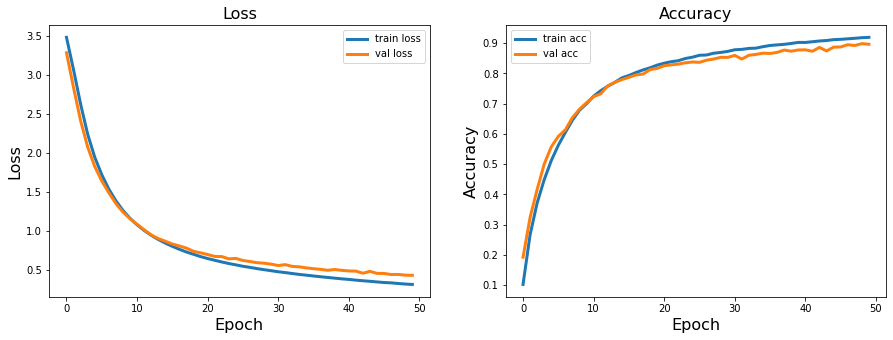

Max validation accuracy=0.898 at epoch=48
Min validation loss=0.43 at epoch=49
__________________________________________________________________________
Learning rate=0.00030000000000000003


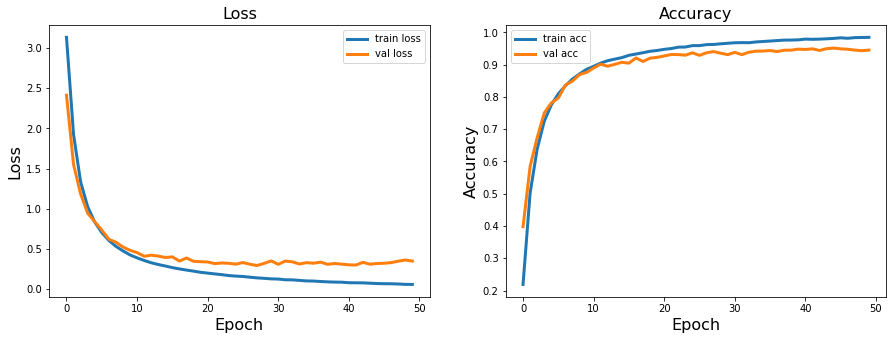

Max validation accuracy=0.951 at epoch=44
Min validation loss=0.295 at epoch=27
__________________________________________________________________________
Learning rate=0.0005000000000000001


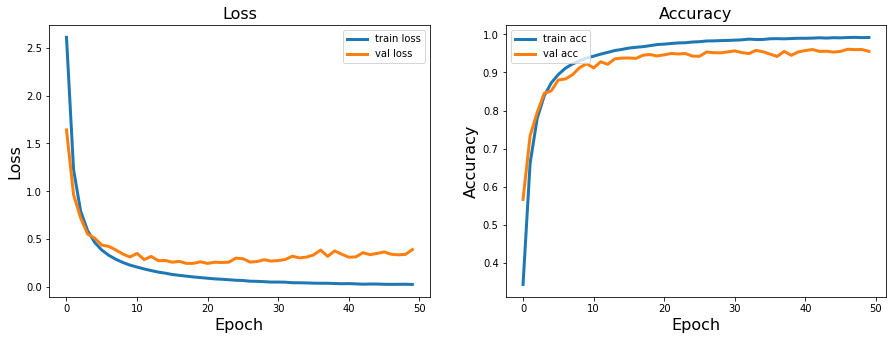

Max validation accuracy=0.961 at epoch=46
Min validation loss=0.247 at epoch=20
__________________________________________________________________________
Learning rate=0.0007000000000000001


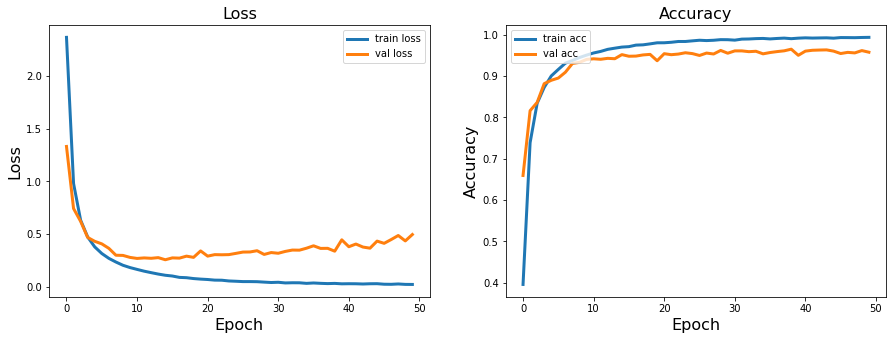

Max validation accuracy=0.965 at epoch=38
Min validation loss=0.258 at epoch=14
__________________________________________________________________________
Learning rate=0.0009000000000000002


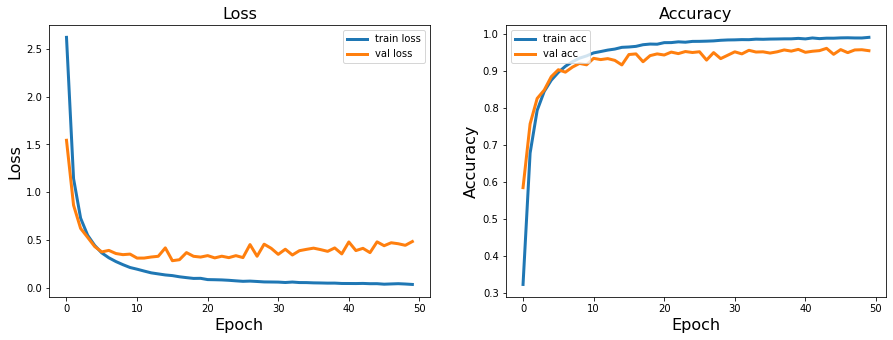

Max validation accuracy=0.961 at epoch=43
Min validation loss=0.282 at epoch=15
__________________________________________________________________________
Learning rate=0.0011000000000000003


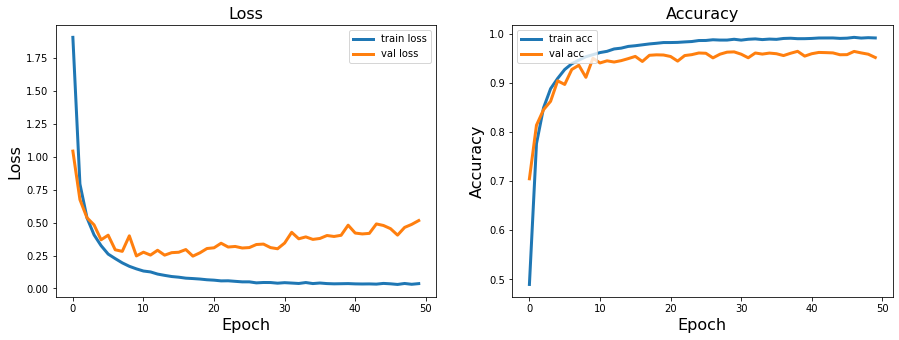

Max validation accuracy=0.964 at epoch=38
Min validation loss=0.245 at epoch=17
__________________________________________________________________________
Learning rate=0.0013000000000000002


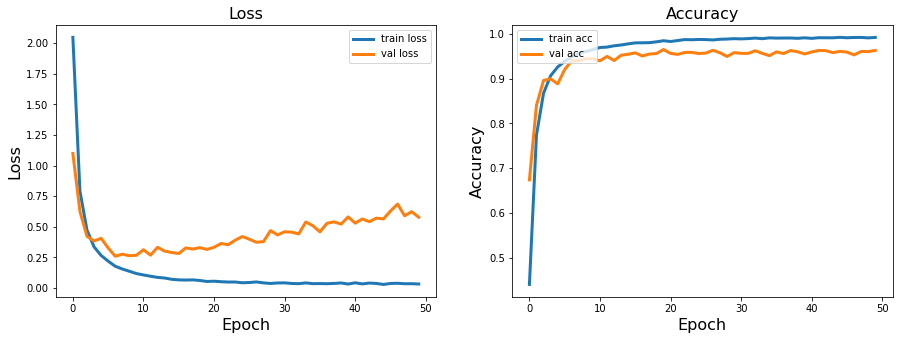

Max validation accuracy=0.965 at epoch=19
Min validation loss=0.259 at epoch=6
__________________________________________________________________________
Learning rate=0.0015000000000000002


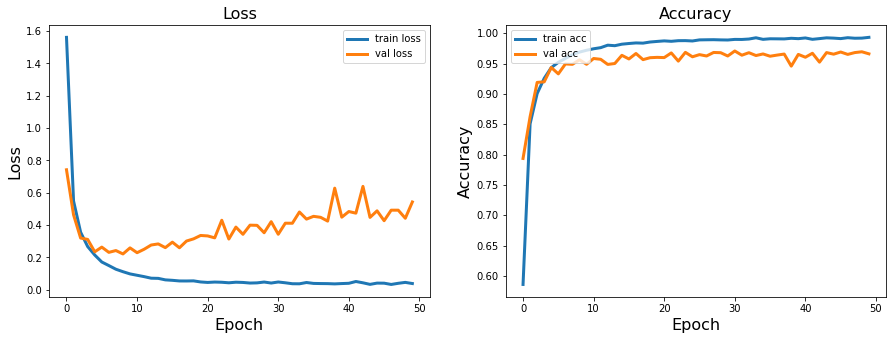

Max validation accuracy=0.971 at epoch=30
Min validation loss=0.221 at epoch=8
__________________________________________________________________________
Learning rate=0.0017000000000000003


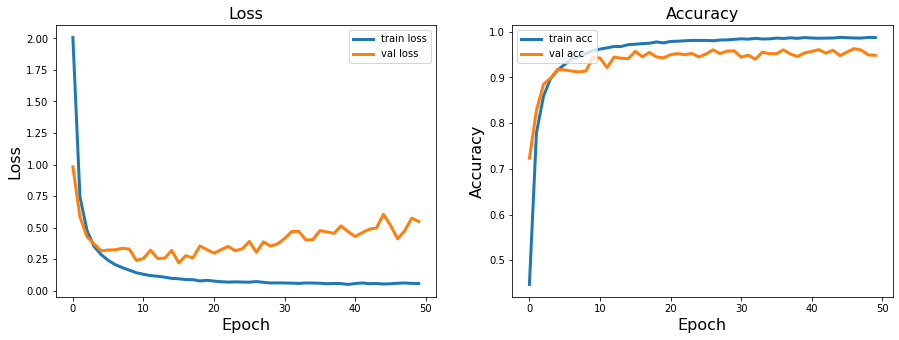

Max validation accuracy=0.963 at epoch=46
Min validation loss=0.22 at epoch=15
__________________________________________________________________________
Learning rate=0.0019000000000000004


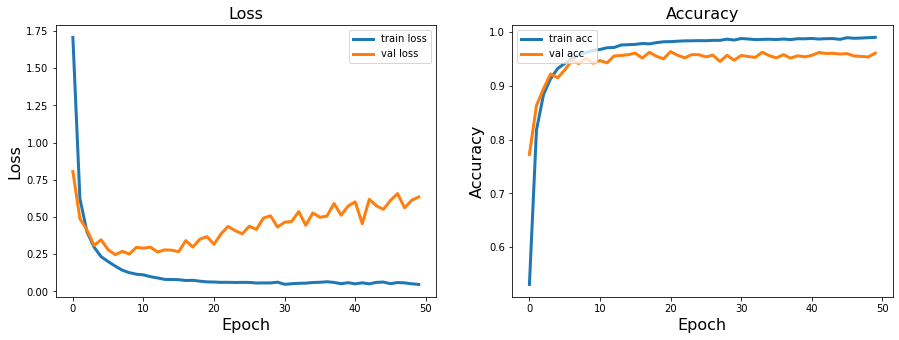

Max validation accuracy=0.964 at epoch=20
Min validation loss=0.247 at epoch=6
__________________________________________________________________________
Learning rate=0.0021000000000000003


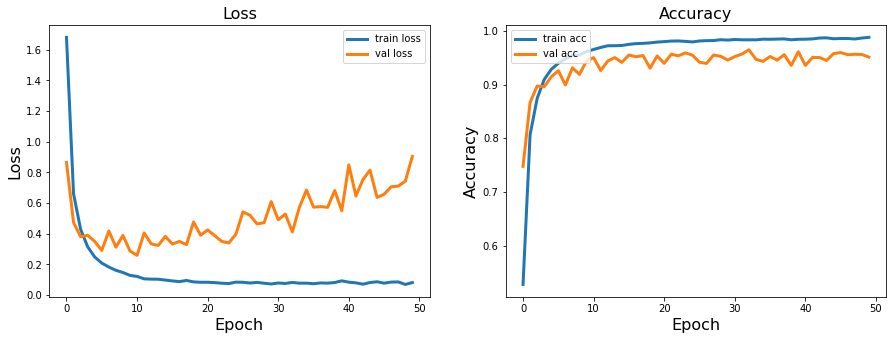

Max validation accuracy=0.965 at epoch=32
Min validation loss=0.259 at epoch=10
__________________________________________________________________________
Learning rate=0.0023000000000000004


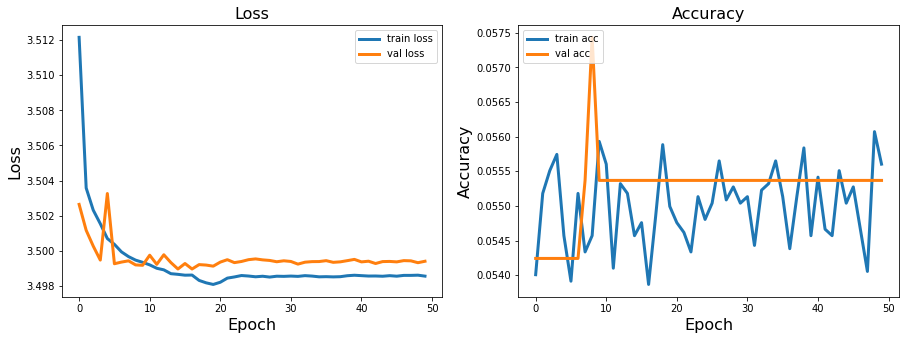

Max validation accuracy=0.057 at epoch=8
Min validation loss=3.499 at epoch=14
__________________________________________________________________________
Learning rate=0.0025


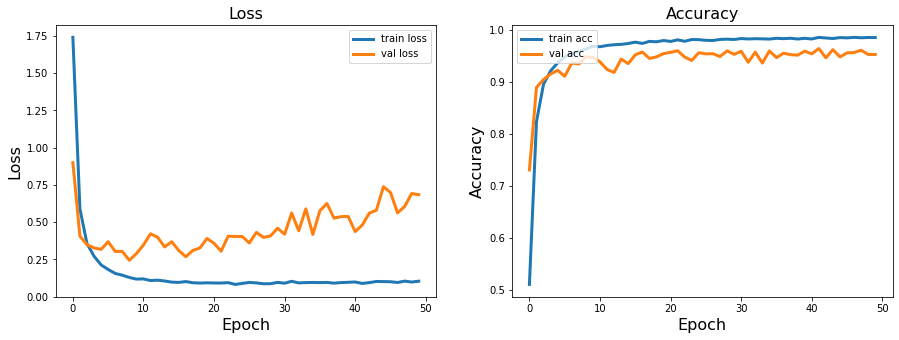

Max validation accuracy=0.964 at epoch=41
Min validation loss=0.244 at epoch=8
__________________________________________________________________________
Learning rate=0.0027


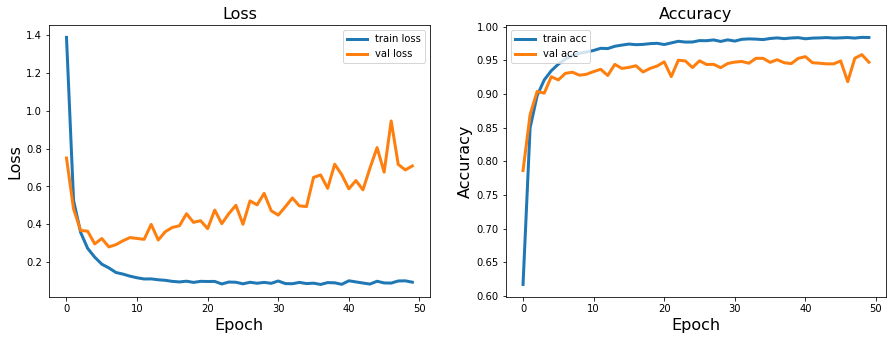

Max validation accuracy=0.958 at epoch=48
Min validation loss=0.28 at epoch=6
__________________________________________________________________________
Learning rate=0.0029000000000000002


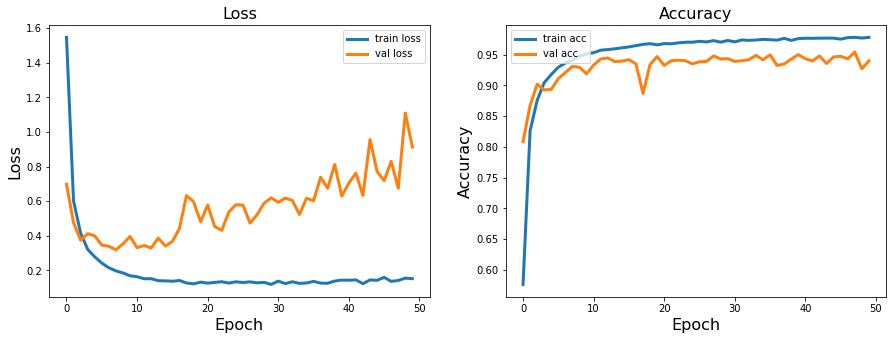

Max validation accuracy=0.954 at epoch=47
Min validation loss=0.32 at epoch=7


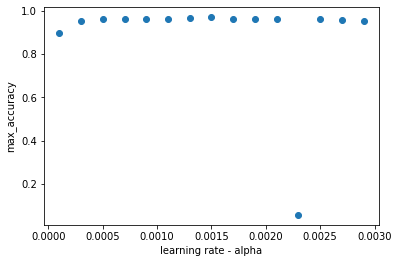

In [25]:
# learning rates (alpha values)   
alpha = np.arange(0.0001, 0.003, 0.0002)

val_accuracies = [] # store validation accuracies

# Train models for each learning rate (alpha) values produced
for i, a in enumerate(alpha):
    model = lr_CNN()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=a),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    history = model.fit(x=train_dataset,  
                        epochs=50, 
                        validation_data=validation_dataset,
                        verbose=0)
    print('__________________________________________________________________________')
    print(f'Learning rate={alpha[i]}')
    display_metrics(history)
    val_accuracies.append(np.max(history.history['val_accuracy']))

# Scatter graph for alpha value and its validation accuracy
plt.scatter(alpha, val_accuracies)
plt.xlabel("learning rate - alpha")
plt.ylabel("max_accuracy")
plt.show()

Although the result shows that the maximum validation accuracies are similar for all arranged learning rates, the higher laearning rate result in overfitting. For the further model development, the learning rate of 0.001 will be used.

## L1 Regularizing :
- <b>L1 regularization:</b> The cost is added proportional to the absolute value of the weight coefficients.
- The regularization is added to one of the dense layer.
- The regularizations values are arranged between 0.001~0.009 with 0.001 increments.

In [34]:
# Experimenting with different regularization values
def regularized_CNN(reg):
    model = tf.keras.models.Sequential()
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l1(reg)))
    model.add(tf.keras.layers.Dense(84, activation='relu',
             kernel_regularizer=tf.keras.regularizers.l1(reg)))
    model.add(tf.keras.layers.Dense(43))
    return model

__________________________________________________________________________
Regularization value=0.001


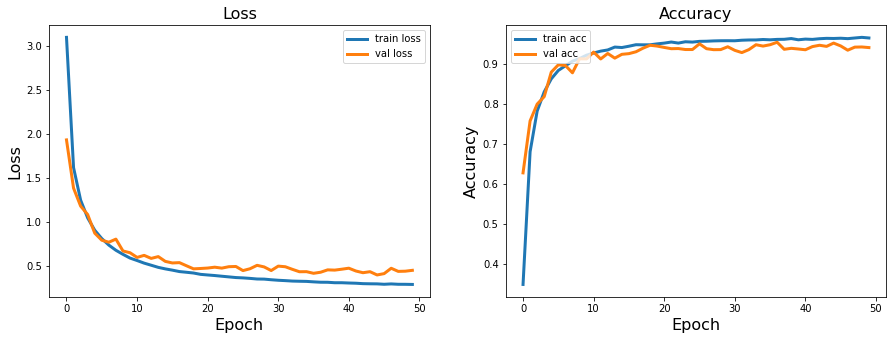

Max validation accuracy=0.955 at epoch=36
Min validation loss=0.401 at epoch=44
__________________________________________________________________________
Regularization value=0.002


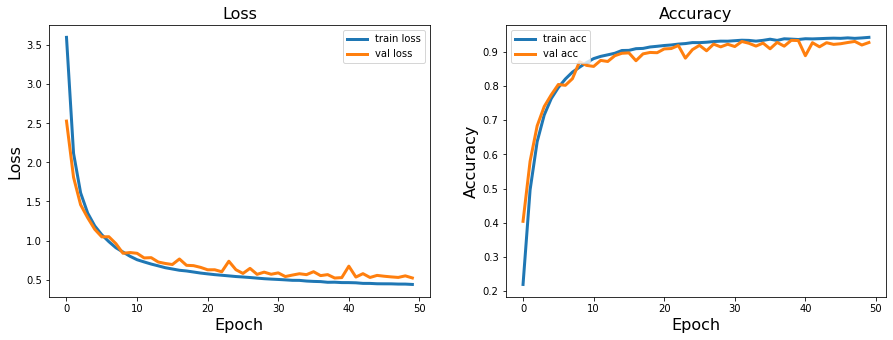

Max validation accuracy=0.934 at epoch=38
Min validation loss=0.521 at epoch=38
__________________________________________________________________________
Regularization value=0.003


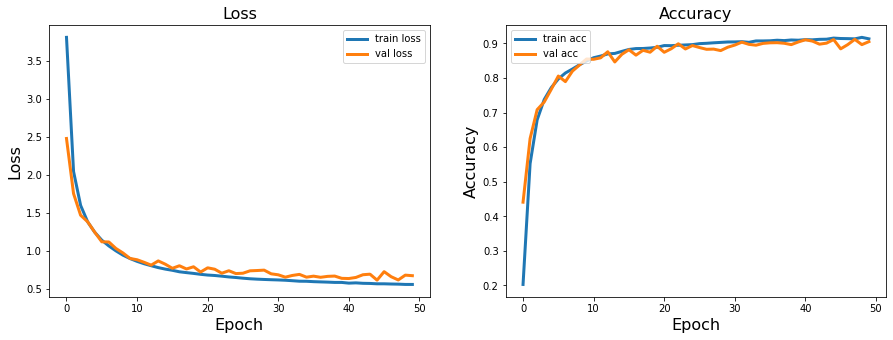

Max validation accuracy=0.912 at epoch=47
Min validation loss=0.617 at epoch=44
__________________________________________________________________________
Regularization value=0.004


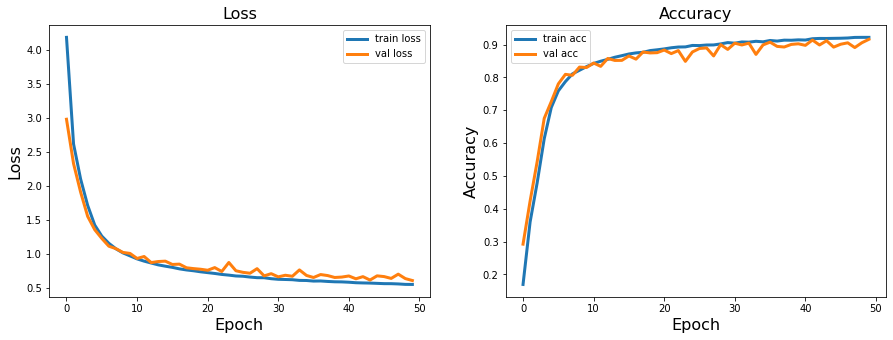

Max validation accuracy=0.916 at epoch=49
Min validation loss=0.607 at epoch=49
__________________________________________________________________________
Regularization value=0.005


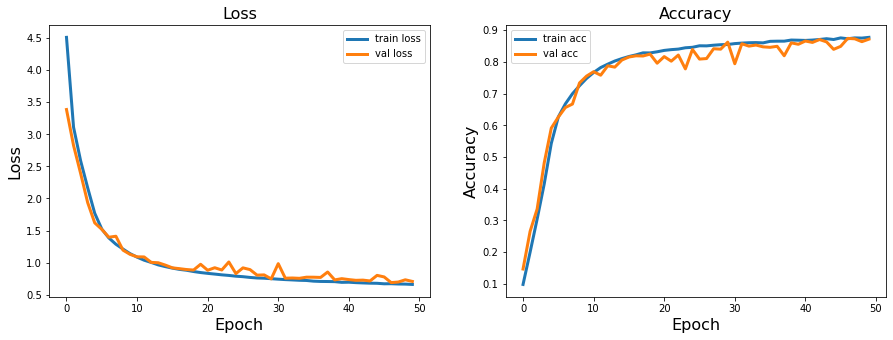

Max validation accuracy=0.874 at epoch=46
Min validation loss=0.688 at epoch=46
__________________________________________________________________________
Regularization value=0.006


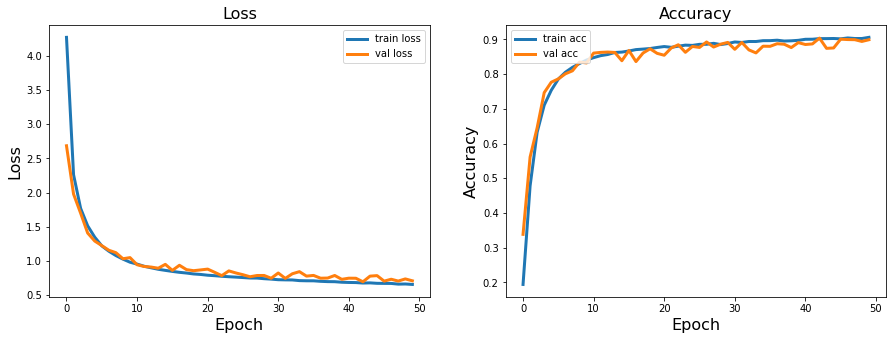

Max validation accuracy=0.904 at epoch=42
Min validation loss=0.692 at epoch=42
__________________________________________________________________________
Regularization value=0.007


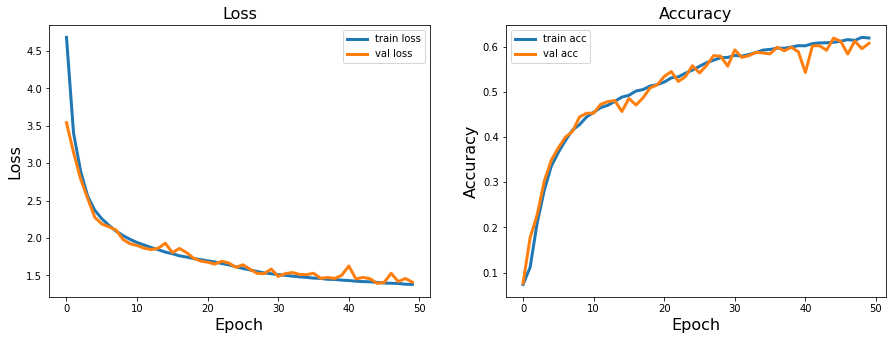

Max validation accuracy=0.619 at epoch=44
Min validation loss=1.393 at epoch=44
__________________________________________________________________________
Regularization value=0.008


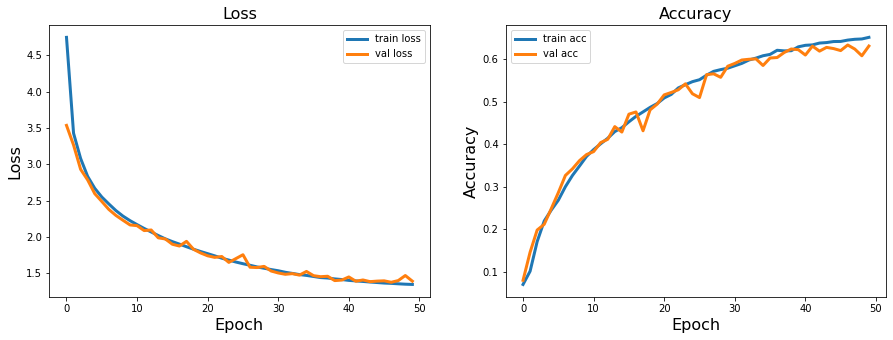

Max validation accuracy=0.633 at epoch=46
Min validation loss=1.375 at epoch=46


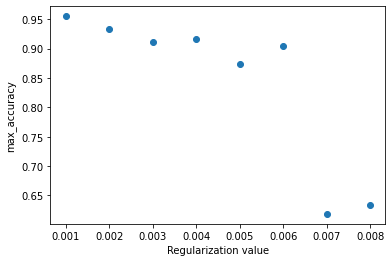

In [35]:
# L1 values   
reg_values = np.arange(0.001, 0.009, 0.001)

val_accuracies = [] # store validation accuracies

# Train models for each L1 value produced
for i, reg in enumerate(reg_values):
    model = regularized_CNN(reg)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    history = model.fit(x=train_dataset,  
                        epochs=50, 
                        validation_data=validation_dataset,
                        verbose=0)
    print('__________________________________________________________________________')
    print(f'Regularization value={reg_values[i]}')
    display_metrics(history)
    val_accuracies.append(np.max(history.history['val_accuracy']))

# Scatter graph for regularization values and its validation accuracies
plt.scatter(reg_values, val_accuracies)
plt.xlabel("Regularization value")
plt.ylabel("max_accuracy")
plt.show()

The L1 regularization smooth out the convergence of the model and improve avoiding overfitting of the model. The validation accuracy is highest at 0.001 and it decreases with the increment.

## Convolutional Model with Dropout :
<b>Dropout</b> [3] is added as the end of convolutional and fully-connected layers. The dropout layer randomly sets the output of the neuron to be zero. This would increase the nonlinearity of the model and help avoid overfitting. 

In [36]:
# Lenet-5 inspired Convolutional Nueral Network architecture with dropouts
def dropout_CNN(d_rate):
    model = tf.keras.models.Sequential()
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Dropout(d_rate))
    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dense(84, activation='relu'))
    model.add(tf.keras.layers.Dropout(d_rate))
    model.add(tf.keras.layers.Dense(43))
    return model

___________________________________________________________________________________
Dropout rate=0.1


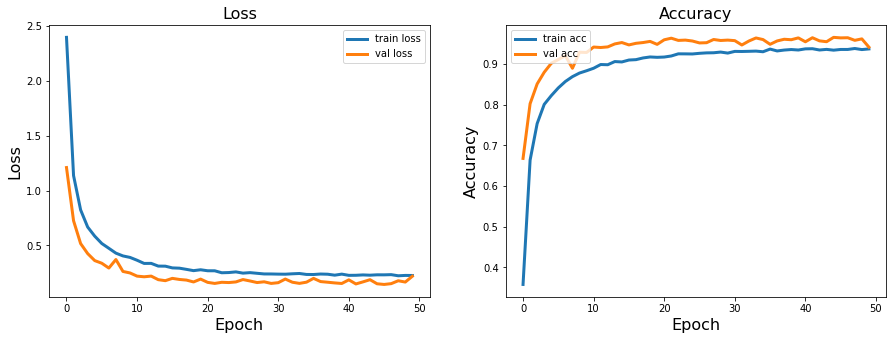

Max validation accuracy=0.965 at epoch=44
Min validation loss=0.143 at epoch=45
___________________________________________________________________________________
Dropout rate=0.2


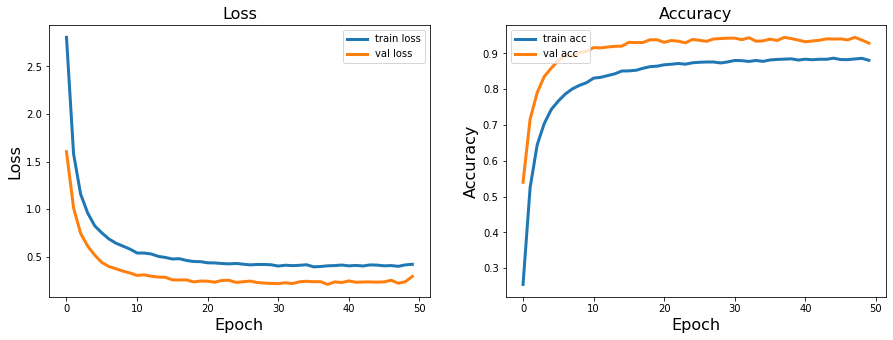

Max validation accuracy=0.945 at epoch=37
Min validation loss=0.21 at epoch=37
___________________________________________________________________________________
Dropout rate=0.30000000000000004


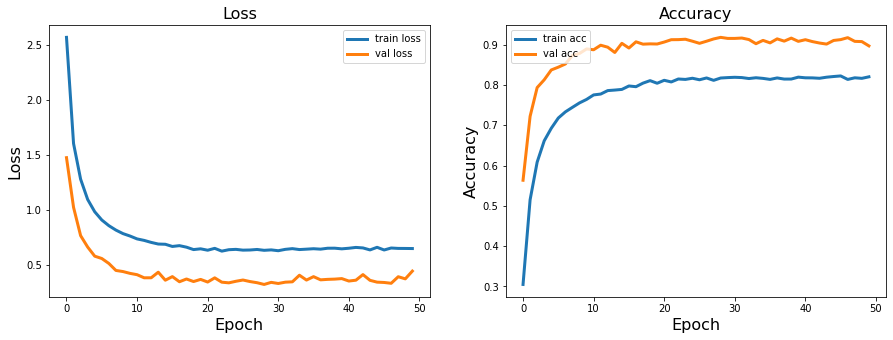

Max validation accuracy=0.918 at epoch=28
Min validation loss=0.325 at epoch=28
___________________________________________________________________________________
Dropout rate=0.4


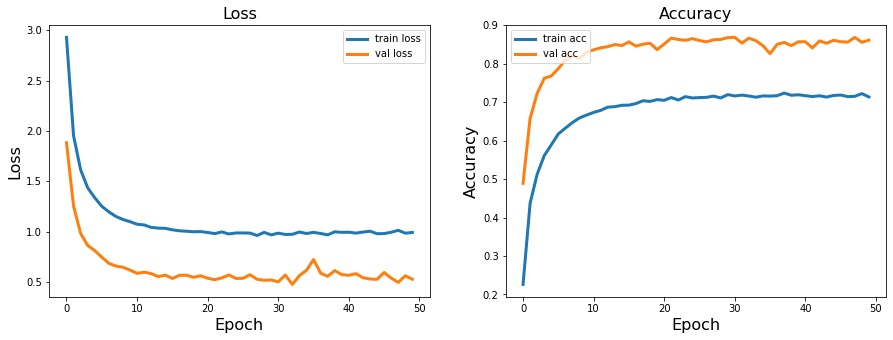

Max validation accuracy=0.868 at epoch=30
Min validation loss=0.475 at epoch=32
___________________________________________________________________________________
Dropout rate=0.5


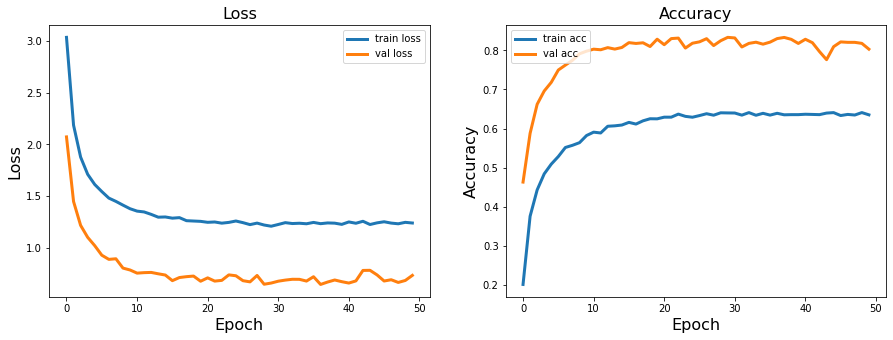

Max validation accuracy=0.833 at epoch=29
Min validation loss=0.647 at epoch=36
___________________________________________________________________________________
Dropout rate=0.6


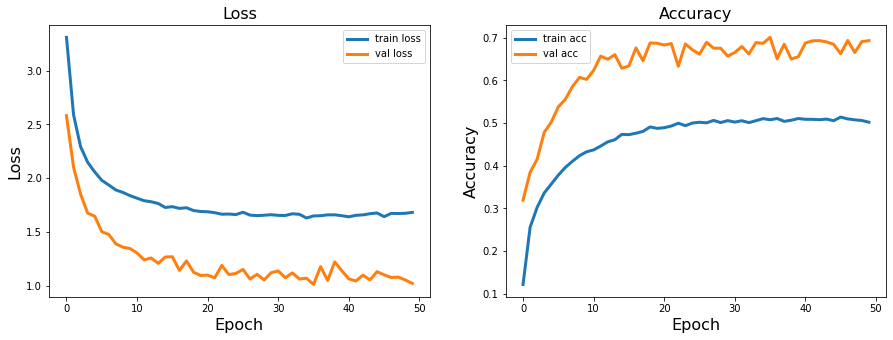

Max validation accuracy=0.701 at epoch=35
Min validation loss=1.012 at epoch=35
___________________________________________________________________________________
Dropout rate=0.7000000000000001


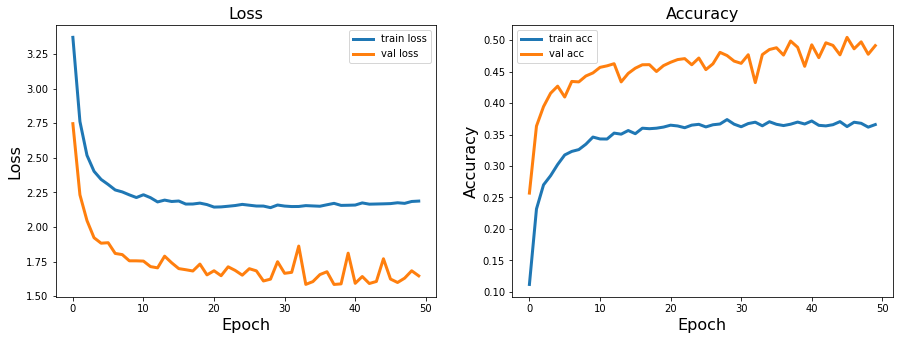

Max validation accuracy=0.504 at epoch=45
Min validation loss=1.586 at epoch=37
___________________________________________________________________________________
Dropout rate=0.8


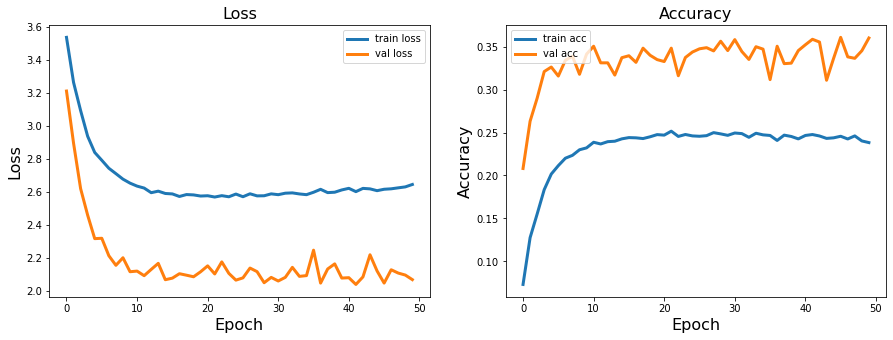

Max validation accuracy=0.361 at epoch=45
Min validation loss=2.04 at epoch=41


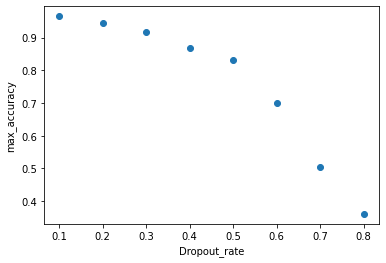

In [37]:
# Dropout rates   
dropouts = np.arange(0.1, 0.9, 0.1)

val_accuracies = [] # store validation accuracies

# Train models for each Dropout rate.
for i, d_rate in enumerate(dropouts):
    model = dropout_CNN(d_rate)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    history = model.fit(x=train_dataset,  
                        epochs=50, 
                        validation_data=validation_dataset,
                        verbose=0)
    print('___________________________________________________________________________________')
    print(f'Dropout rate={dropouts[i]}')
    display_metrics(history)
    val_accuracies.append(np.max(history.history['val_accuracy']))

# Scatter graph for Dropout rates and its validation accuracies
plt.scatter(dropouts, val_accuracies)
plt.xlabel("Dropout_rate")
plt.ylabel("max_accuracy")
plt.show()

The model suffers to learn with a high dropout rate value. The validation accuracy is the highest with the droprate of 0.1 and performance decreases as the dropout rate increases.

## Model Capacity:
Different numbers of neurons of the dense layers are tested between 120 and 500 with an increment of 50 neurons.

In [38]:
# Lenet-5 inspired Convolutional Nueral Network architecture
def model_capacity_CNN(neurons):
    model = tf.keras.models.Sequential()
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(3, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(43))
    return model

___________________________________________________________________________________
Number of neurons=120


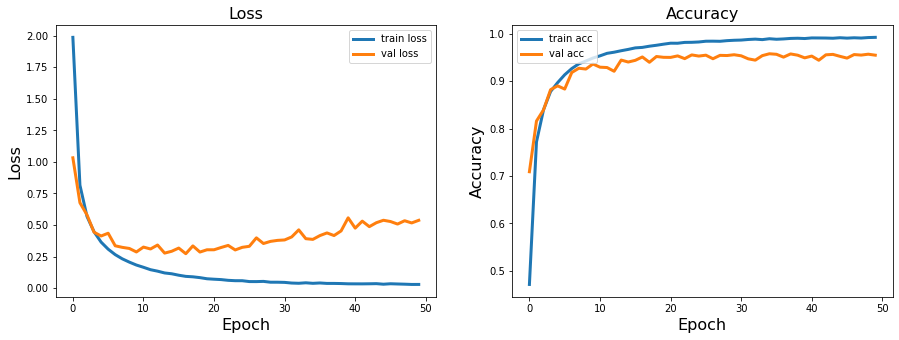

Max validation accuracy=0.958 at epoch=34
Min validation loss=0.272 at epoch=16
___________________________________________________________________________________
Number of neurons=170


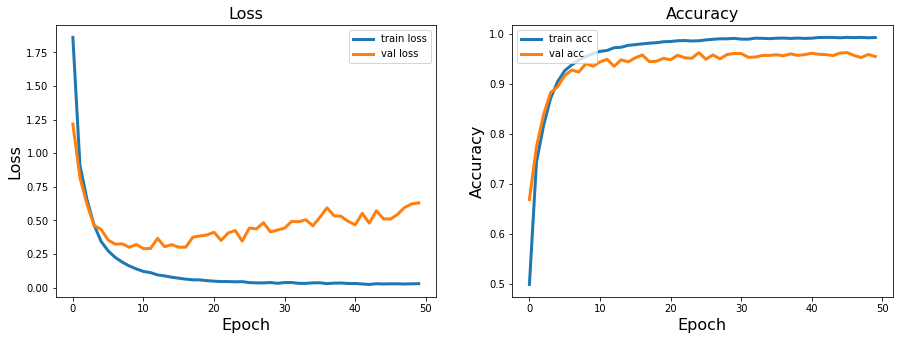

Max validation accuracy=0.963 at epoch=45
Min validation loss=0.29 at epoch=10
___________________________________________________________________________________
Number of neurons=220


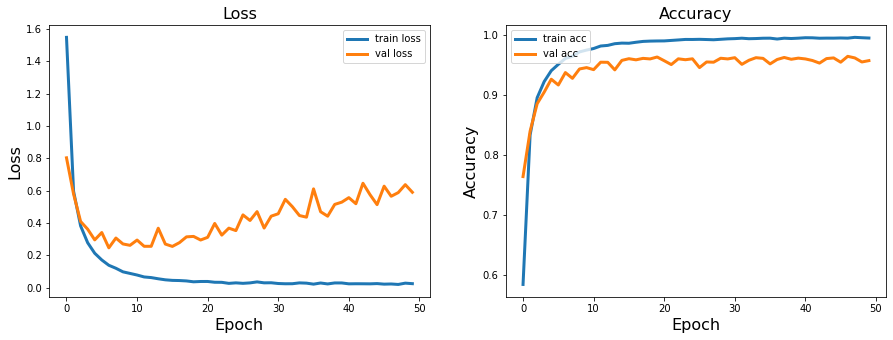

Max validation accuracy=0.964 at epoch=46
Min validation loss=0.246 at epoch=6
___________________________________________________________________________________
Number of neurons=270


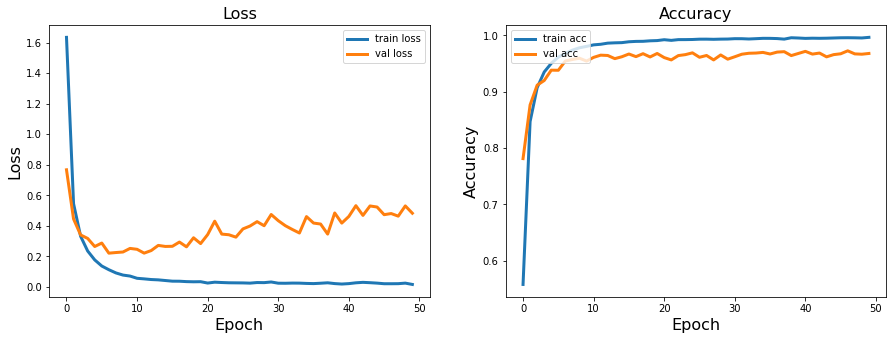

Max validation accuracy=0.973 at epoch=46
Min validation loss=0.221 at epoch=6
___________________________________________________________________________________
Number of neurons=320


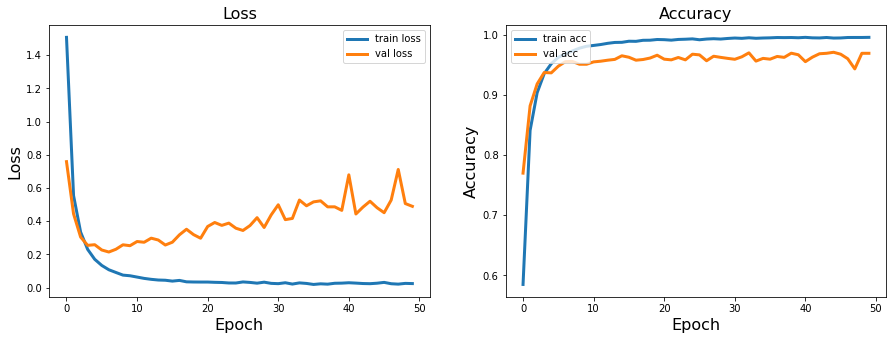

Max validation accuracy=0.971 at epoch=44
Min validation loss=0.215 at epoch=6
___________________________________________________________________________________
Number of neurons=370


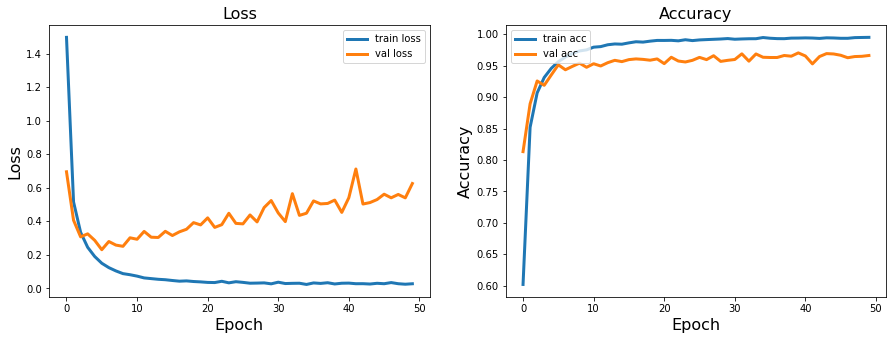

Max validation accuracy=0.97 at epoch=39
Min validation loss=0.23 at epoch=5
___________________________________________________________________________________
Number of neurons=420


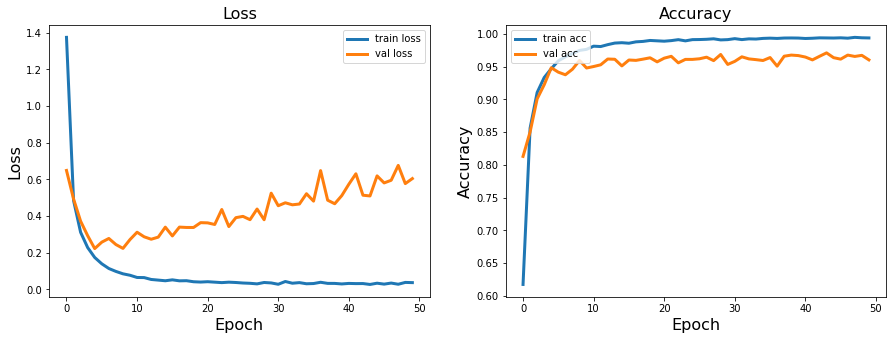

Max validation accuracy=0.971 at epoch=43
Min validation loss=0.222 at epoch=4
___________________________________________________________________________________
Number of neurons=470


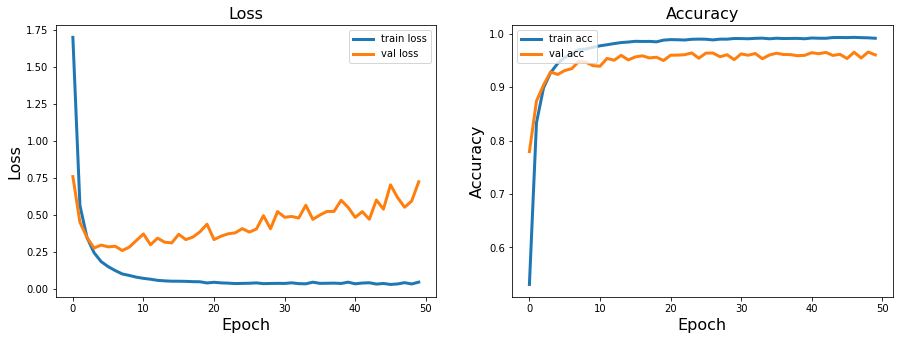

Max validation accuracy=0.966 at epoch=48
Min validation loss=0.261 at epoch=7


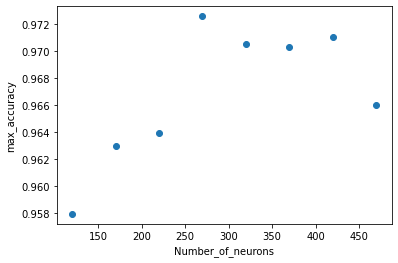

In [39]:
# Number of neurons   
num_neurons = np.arange(120, 500, 50)

val_accuracies = [] # store validation accuracies

# Train models for each number of neurons.
for i, neurons in enumerate(num_neurons):
    model = model_capacity_CNN(neurons)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    history = model.fit(x=train_dataset,  
                        epochs=50, 
                        validation_data=validation_dataset,
                        verbose=0)
    print('___________________________________________________________________________________')
    print(f'Number of neurons={num_neurons[i]}')
    display_metrics(history)
    val_accuracies.append(np.max(history.history['val_accuracy']))

# Scatter graph for number of neurons and its validation accuracies
plt.scatter(num_neurons, val_accuracies)
plt.xlabel("Number_of_neurons")
plt.ylabel("max_accuracy")
plt.show()

The validation accuracy increases slightly With the increase of the capacity. The number of neurons above 270 seem to perform well.

## Number of Filters:
Different numbers of convolutional filters between 3 and 100 with an increment of 6 filters are evaluated.

In [40]:
# Lenet-5 inspired Convolutional Nueral Network architecture
def filter_size_CNN(filters):
    model = tf.keras.models.Sequential()
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(filters, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(filters, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dense(80, activation='relu'))
    model.add(tf.keras.layers.Dense(43))
    return model

___________________________________________________________________________________
Number of filters=3


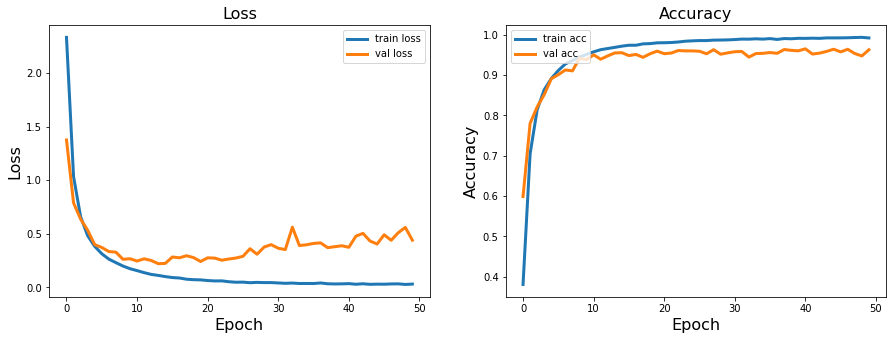

Max validation accuracy=0.965 at epoch=40
Min validation loss=0.221 at epoch=13
___________________________________________________________________________________
Number of filters=9


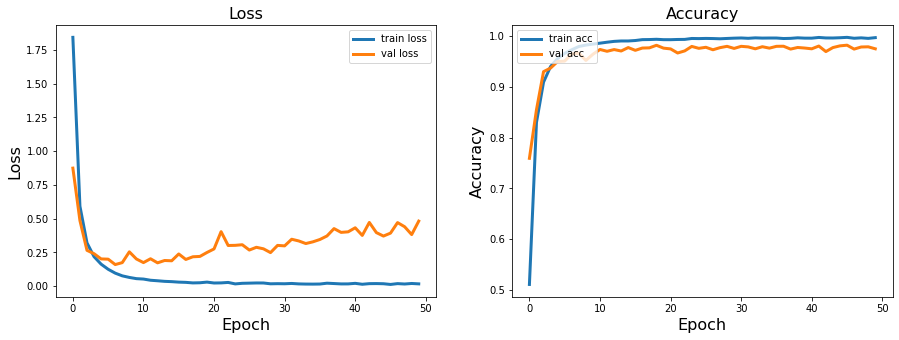

Max validation accuracy=0.982 at epoch=45
Min validation loss=0.16 at epoch=6
___________________________________________________________________________________
Number of filters=15


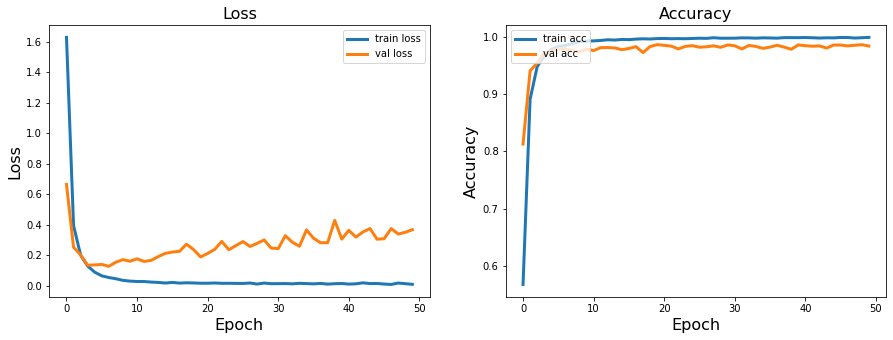

Max validation accuracy=0.986 at epoch=19
Min validation loss=0.126 at epoch=6
___________________________________________________________________________________
Number of filters=21


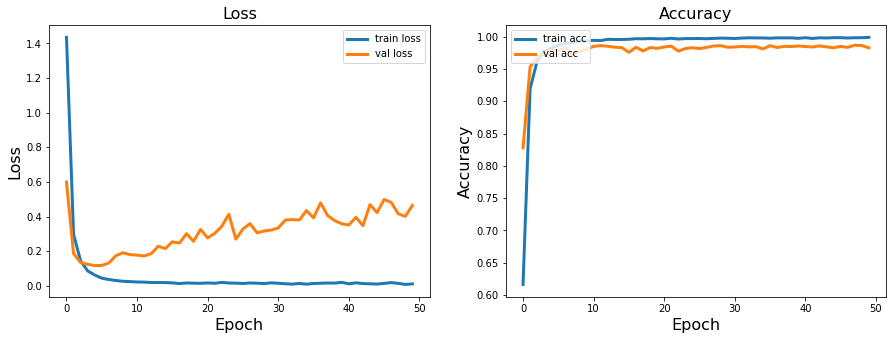

Max validation accuracy=0.987 at epoch=47
Min validation loss=0.117 at epoch=4
___________________________________________________________________________________
Number of filters=27


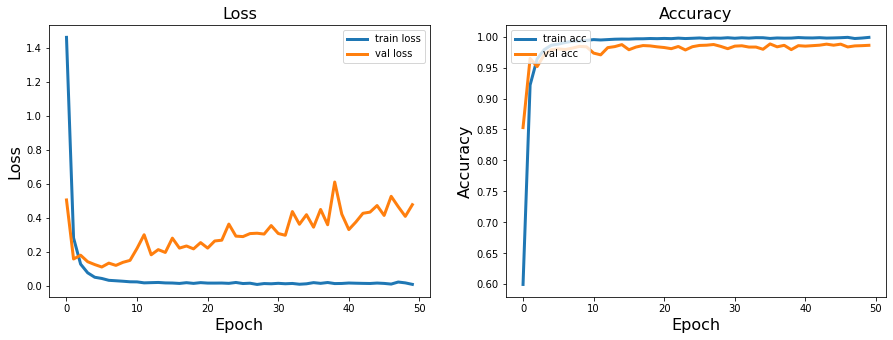

Max validation accuracy=0.988 at epoch=35
Min validation loss=0.111 at epoch=5
___________________________________________________________________________________
Number of filters=33


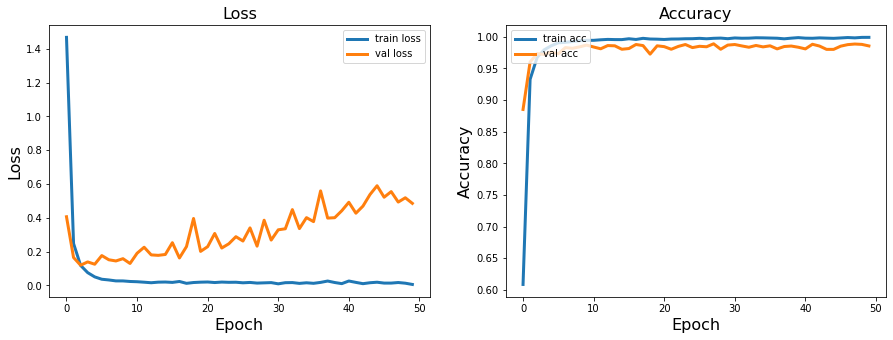

Max validation accuracy=0.989 at epoch=27
Min validation loss=0.119 at epoch=2
___________________________________________________________________________________
Number of filters=39


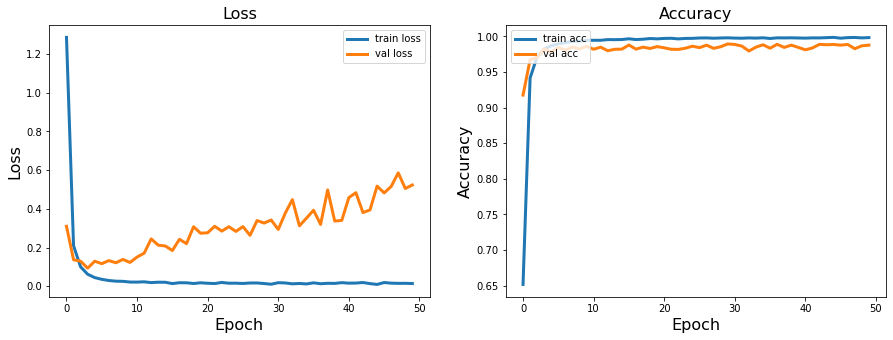

Max validation accuracy=0.989 at epoch=29
Min validation loss=0.093 at epoch=3
___________________________________________________________________________________
Number of filters=45


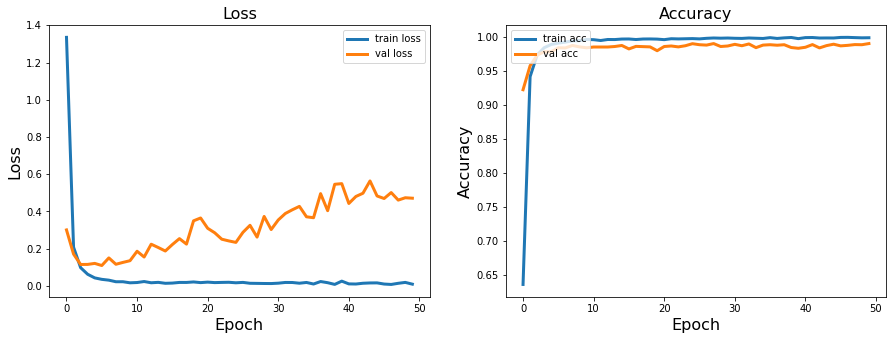

Max validation accuracy=0.99 at epoch=27
Min validation loss=0.109 at epoch=5
___________________________________________________________________________________
Number of filters=51


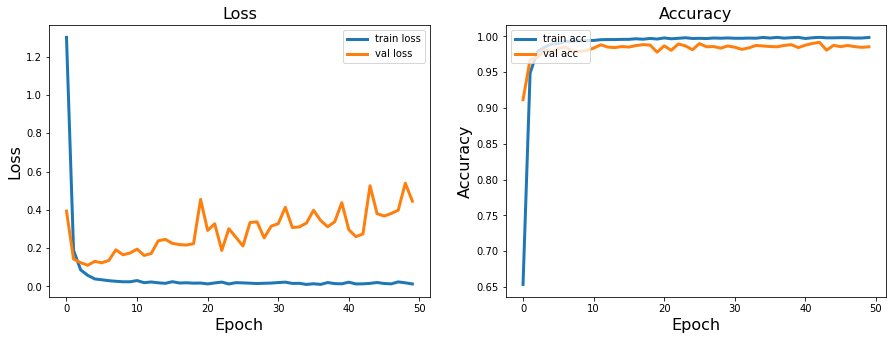

Max validation accuracy=0.992 at epoch=42
Min validation loss=0.11 at epoch=3
___________________________________________________________________________________
Number of filters=57


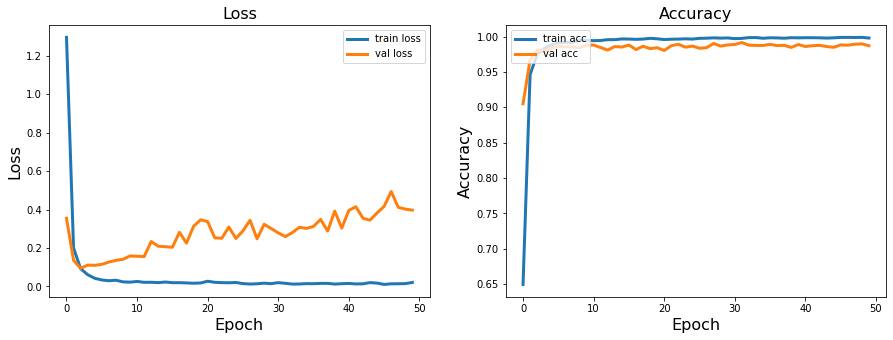

Max validation accuracy=0.992 at epoch=31
Min validation loss=0.094 at epoch=2
___________________________________________________________________________________
Number of filters=63


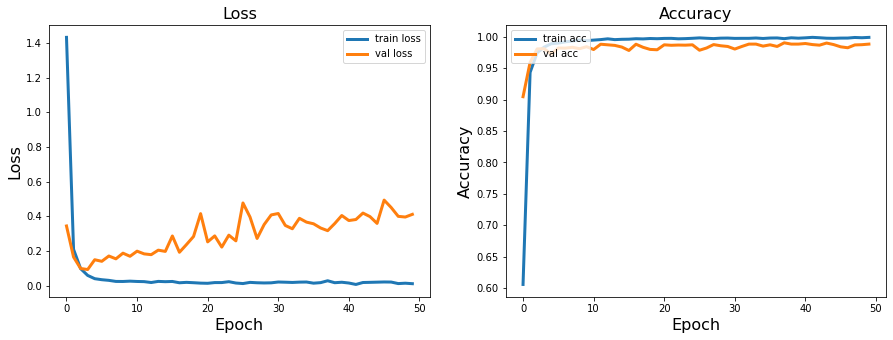

Max validation accuracy=0.99 at epoch=37
Min validation loss=0.092 at epoch=3
___________________________________________________________________________________
Number of filters=69


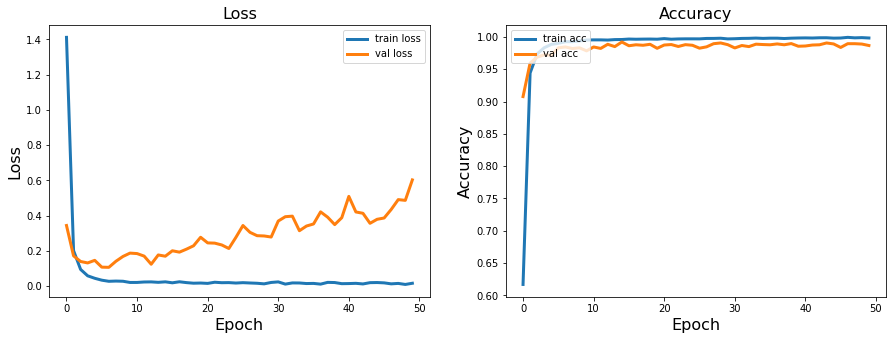

Max validation accuracy=0.992 at epoch=14
Min validation loss=0.107 at epoch=6
___________________________________________________________________________________
Number of filters=75


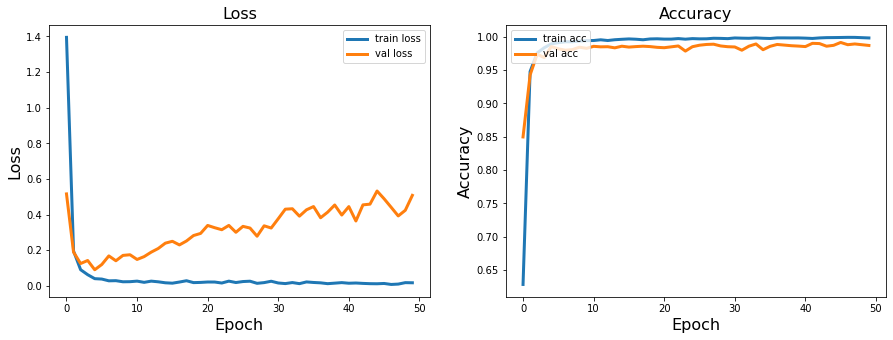

Max validation accuracy=0.991 at epoch=45
Min validation loss=0.091 at epoch=4
___________________________________________________________________________________
Number of filters=81


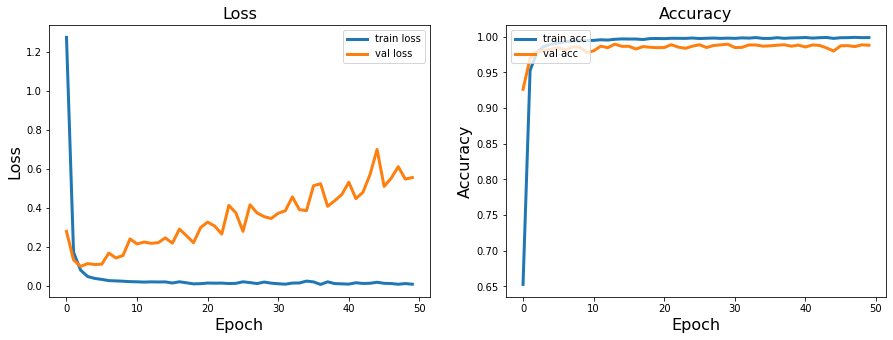

Max validation accuracy=0.989 at epoch=13
Min validation loss=0.102 at epoch=2
___________________________________________________________________________________
Number of filters=87


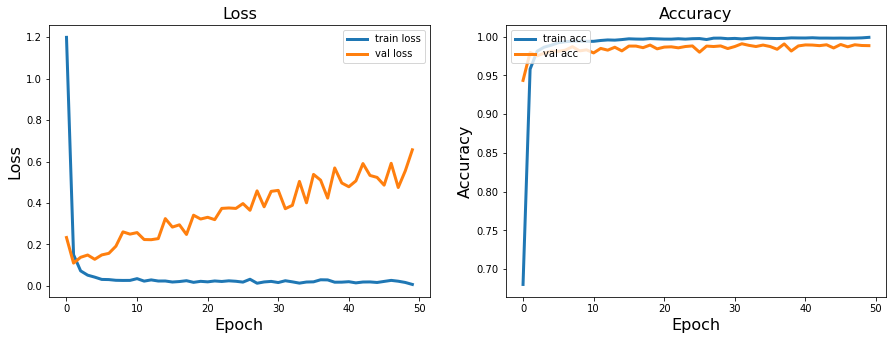

Max validation accuracy=0.991 at epoch=31
Min validation loss=0.109 at epoch=1
___________________________________________________________________________________
Number of filters=93


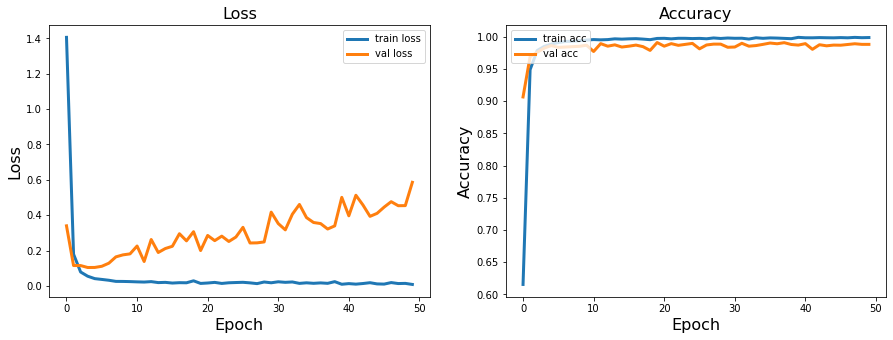

Max validation accuracy=0.991 at epoch=19
Min validation loss=0.104 at epoch=3
___________________________________________________________________________________
Number of filters=99


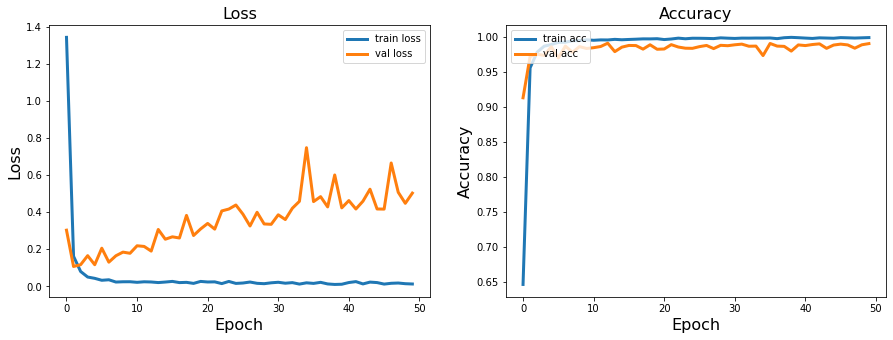

Max validation accuracy=0.991 at epoch=12
Min validation loss=0.107 at epoch=1


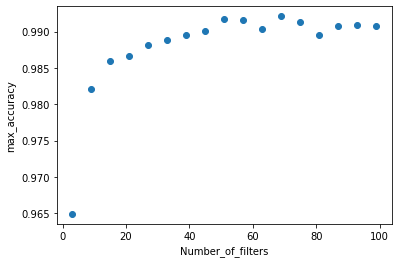

In [41]:
# Number of filters   
num_filters = np.arange(3, 100, 6)

val_accuracies = [] # store validation accuracies

# Train models for each number of filters.
for i, filters in enumerate(num_filters):
    model = filter_size_CNN(filters)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    history = model.fit(x=train_dataset,  
                        epochs=50, 
                        validation_data=validation_dataset,
                        verbose=0)
    print('___________________________________________________________________________________')
    print(f'Number of filters={num_filters[i]}')
    display_metrics(history)
    val_accuracies.append(np.max(history.history['val_accuracy']))

# Scatter graph for number of neurons and its validation accuracies
plt.scatter(num_filters, val_accuracies)
plt.xlabel("Number_of_filters")
plt.ylabel("max_accuracy")
plt.show()

The increase of the filter size improved the validation accuracy, however, it had also caused the overfit of the model.

## Final model Training:
Using best performing values from above expolorations for each hyper parameter setting:
  - Learning rate = 0.001
  - L1 regularization = 0.001
  - Dropout rate = 0.1
  - Model capacity = 270
  - Number convolutional filters = 70

In [48]:
def final_lenet_5_CNN():
    model = tf.keras.models.Sequential()
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(70, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(70, 5, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Dropout(0.1))

    #Fully-connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(270, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1(0.001)))
    model.add(tf.keras.layers.Dense(270, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1(0.001)))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(43))
    return model

Epoch 1/300
666/666 [==============================] - 4s 5ms/step - loss: 3.4026 - accuracy: 0.3218 - val_loss: 1.6938 - val_accuracy: 0.6742
Epoch 2/300
666/666 [==============================] - 3s 5ms/step - loss: 1.3259 - accuracy: 0.7833 - val_loss: 1.0112 - val_accuracy: 0.9024
Epoch 3/300
666/666 [==============================] - 4s 6ms/step - loss: 0.9619 - accuracy: 0.9027 - val_loss: 0.9141 - val_accuracy: 0.9043
Epoch 4/300
666/666 [==============================] - 4s 6ms/step - loss: 0.8211 - accuracy: 0.9294 - val_loss: 0.7316 - val_accuracy: 0.9572
Epoch 5/300
666/666 [==============================] - 3s 5ms/step - loss: 0.7341 - accuracy: 0.9447 - val_loss: 0.6926 - val_accuracy: 0.9587
Epoch 6/300
666/666 [==============================] - 4s 5ms/step - loss: 0.6817 - accuracy: 0.9524 - val_loss: 0.6306 - val_accuracy: 0.9700
Epoch 7/300
666/666 [==============================] - 3s 5ms/step - loss: 0.6461 - accuracy: 0.9587 - val_loss: 0.6554 - val_accuracy: 0.9535

Epoch 58/300
666/666 [==============================] - 3s 5ms/step - loss: 0.4113 - accuracy: 0.9842 - val_loss: 0.4444 - val_accuracy: 0.9835
Epoch 59/300
666/666 [==============================] - 3s 5ms/step - loss: 0.4033 - accuracy: 0.9857 - val_loss: 0.4327 - val_accuracy: 0.9825
Epoch 60/300
666/666 [==============================] - 3s 5ms/step - loss: 0.4081 - accuracy: 0.9862 - val_loss: 0.4406 - val_accuracy: 0.9842
Epoch 61/300
666/666 [==============================] - 3s 5ms/step - loss: 0.4046 - accuracy: 0.9853 - val_loss: 0.4253 - val_accuracy: 0.9848
Epoch 62/300
666/666 [==============================] - 3s 5ms/step - loss: 0.4038 - accuracy: 0.9858 - val_loss: 0.4331 - val_accuracy: 0.9840
Epoch 63/300
666/666 [==============================] - 3s 5ms/step - loss: 0.4050 - accuracy: 0.9858 - val_loss: 0.4403 - val_accuracy: 0.9850
Epoch 64/300
666/666 [==============================] - 3s 5ms/step - loss: 0.4006 - accuracy: 0.9868 - val_loss: 0.4831 - val_accuracy:

Epoch 115/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3792 - accuracy: 0.9882 - val_loss: 0.4306 - val_accuracy: 0.9827
Epoch 116/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3791 - accuracy: 0.9877 - val_loss: 0.4185 - val_accuracy: 0.9840
Epoch 117/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3773 - accuracy: 0.9875 - val_loss: 0.4613 - val_accuracy: 0.9754
Epoch 118/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3757 - accuracy: 0.9877 - val_loss: 0.4104 - val_accuracy: 0.9855
Epoch 119/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3774 - accuracy: 0.9884 - val_loss: 0.4662 - val_accuracy: 0.9735
Epoch 120/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3814 - accuracy: 0.9888 - val_loss: 0.4202 - val_accuracy: 0.9833
Epoch 121/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3809 - accuracy: 0.9877 - val_loss: 0.4584 - val_ac

666/666 [==============================] - 3s 5ms/step - loss: 0.3755 - accuracy: 0.9886 - val_loss: 0.4154 - val_accuracy: 0.9850
Epoch 172/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3704 - accuracy: 0.9889 - val_loss: 0.4232 - val_accuracy: 0.9827
Epoch 173/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3826 - accuracy: 0.9876 - val_loss: 0.4141 - val_accuracy: 0.9846
Epoch 174/300
666/666 [==============================] - 3s 5ms/step - loss: 0.3687 - accuracy: 0.9895 - val_loss: 0.4182 - val_accuracy: 0.9861
Epoch 175/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3769 - accuracy: 0.9879 - val_loss: 0.4195 - val_accuracy: 0.9865
Epoch 176/300
666/666 [==============================] - 5s 7ms/step - loss: 0.3729 - accuracy: 0.9889 - val_loss: 0.4590 - val_accuracy: 0.9801
Epoch 177/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3706 - accuracy: 0.9891 - val_loss: 0.4423 - val_accuracy: 0.9779

666/666 [==============================] - 4s 6ms/step - loss: 0.3684 - accuracy: 0.9891 - val_loss: 0.4686 - val_accuracy: 0.9735
Epoch 228/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3764 - accuracy: 0.9874 - val_loss: 0.4170 - val_accuracy: 0.9846
Epoch 229/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3704 - accuracy: 0.9880 - val_loss: 0.4059 - val_accuracy: 0.9863
Epoch 230/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3714 - accuracy: 0.9884 - val_loss: 0.4257 - val_accuracy: 0.9839
Epoch 231/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3663 - accuracy: 0.9899 - val_loss: 0.4080 - val_accuracy: 0.9857
Epoch 232/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3693 - accuracy: 0.9893 - val_loss: 0.4218 - val_accuracy: 0.9861
Epoch 233/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3732 - accuracy: 0.9883 - val_loss: 0.4182 - val_accuracy: 0.9867

666/666 [==============================] - 4s 6ms/step - loss: 0.3803 - accuracy: 0.9875 - val_loss: 0.4719 - val_accuracy: 0.9777
Epoch 284/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3680 - accuracy: 0.9889 - val_loss: 0.4049 - val_accuracy: 0.9857
Epoch 285/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3697 - accuracy: 0.9894 - val_loss: 0.4158 - val_accuracy: 0.9867
Epoch 286/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3743 - accuracy: 0.9869 - val_loss: 0.4329 - val_accuracy: 0.9829
Epoch 287/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3784 - accuracy: 0.9867 - val_loss: 0.4572 - val_accuracy: 0.9807
Epoch 288/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3710 - accuracy: 0.9890 - val_loss: 0.4349 - val_accuracy: 0.9831
Epoch 289/300
666/666 [==============================] - 4s 6ms/step - loss: 0.3660 - accuracy: 0.9891 - val_loss: 0.4186 - val_accuracy: 0.9854

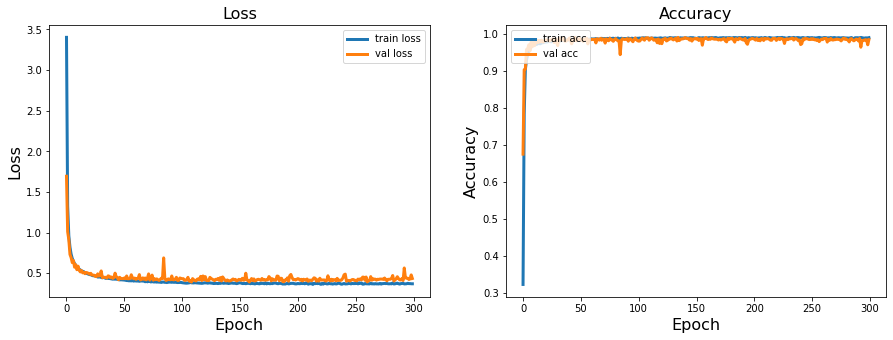

Max validation accuracy=0.99 at epoch=45
Min validation loss=0.391 at epoch=108


In [43]:
# Final overfit training
final_overfit_lenet_5_CNN = final_lenet_5_CNN()
final_overfit_lenet_5_CNN.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
history = final_overfit_lenet_5_CNN.fit(x=train_dataset,  
                    epochs=300, 
                    validation_data=validation_dataset)
print(final_overfit_lenet_5_CNN.summary())
display_metrics(history)

Epoch 1/108
666/666 [==============================] - 4s 6ms/step - loss: 3.4428 - accuracy: 0.3190 - val_loss: 1.6532 - val_accuracy: 0.6911
Epoch 2/108
666/666 [==============================] - 4s 6ms/step - loss: 1.3259 - accuracy: 0.7802 - val_loss: 1.0394 - val_accuracy: 0.8949
Epoch 3/108
666/666 [==============================] - 3s 5ms/step - loss: 0.9584 - accuracy: 0.8969 - val_loss: 0.7924 - val_accuracy: 0.9520
Epoch 4/108
666/666 [==============================] - 3s 5ms/step - loss: 0.8148 - accuracy: 0.9278 - val_loss: 0.7464 - val_accuracy: 0.9480
Epoch 5/108
666/666 [==============================] - 3s 5ms/step - loss: 0.7313 - accuracy: 0.9417 - val_loss: 0.6736 - val_accuracy: 0.9627
Epoch 6/108
666/666 [==============================] - 3s 5ms/step - loss: 0.6701 - accuracy: 0.9530 - val_loss: 0.6307 - val_accuracy: 0.9683
Epoch 7/108
666/666 [==============================] - 3s 5ms/step - loss: 0.6402 - accuracy: 0.9566 - val_loss: 0.6168 - val_accuracy: 0.9677

Epoch 58/108
666/666 [==============================] - 3s 5ms/step - loss: 0.4085 - accuracy: 0.9845 - val_loss: 0.4255 - val_accuracy: 0.9820
Epoch 59/108
666/666 [==============================] - 3s 5ms/step - loss: 0.4095 - accuracy: 0.9854 - val_loss: 0.4115 - val_accuracy: 0.9842
Epoch 60/108
666/666 [==============================] - 3s 5ms/step - loss: 0.4022 - accuracy: 0.9852 - val_loss: 0.4042 - val_accuracy: 0.9865
Epoch 61/108
666/666 [==============================] - 3s 4ms/step - loss: 0.4006 - accuracy: 0.9858 - val_loss: 0.4260 - val_accuracy: 0.9810
Epoch 62/108
666/666 [==============================] - 3s 5ms/step - loss: 0.3987 - accuracy: 0.9860 - val_loss: 0.4066 - val_accuracy: 0.9874
Epoch 63/108
666/666 [==============================] - 3s 5ms/step - loss: 0.4021 - accuracy: 0.9859 - val_loss: 0.4692 - val_accuracy: 0.9784
Epoch 64/108
666/666 [==============================] - 3s 5ms/step - loss: 0.4045 - accuracy: 0.9865 - val_loss: 0.4058 - val_accuracy:

 dropout_36 (Dropout)        (None, 5, 5, 70)          0         
                                                                 
 flatten_107 (Flatten)       (None, 1750)              0         
                                                                 
 dense_319 (Dense)           (None, 270)               472770    
                                                                 
 dense_320 (Dense)           (None, 270)               73170     
                                                                 
 dropout_37 (Dropout)        (None, 270)               0         
                                                                 
 dense_321 (Dense)           (None, 43)                11653     
                                                                 
Total params: 685,483
Trainable params: 685,483
Non-trainable params: 0
_________________________________________________________________
None


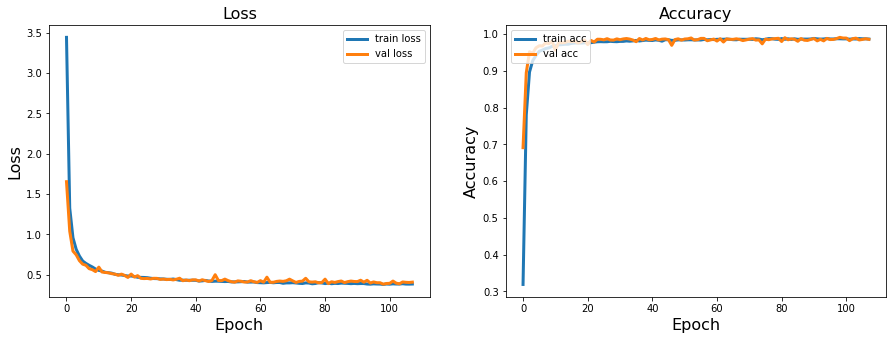

Max validation accuracy=0.991 at epoch=98
Min validation loss=0.382 at epoch=98


In [49]:
# Final Training
final_lenet_5_CNN = final_lenet_5_CNN()
final_lenet_5_CNN.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
history = final_lenet_5_CNN.fit(x=train_dataset,  
                    epochs=108, 
                    validation_data=validation_dataset)
print(final_lenet_5_CNN.summary())
display_metrics(history)

Optimal hyper parameter settings increased the validation accuracies while avoiding overfitting of the model.  The validation and training losses are decreasing tightly together.

## Evaluating with Test Dataset:
Both initial overfitting and final models are evaluated with the test dataset. 

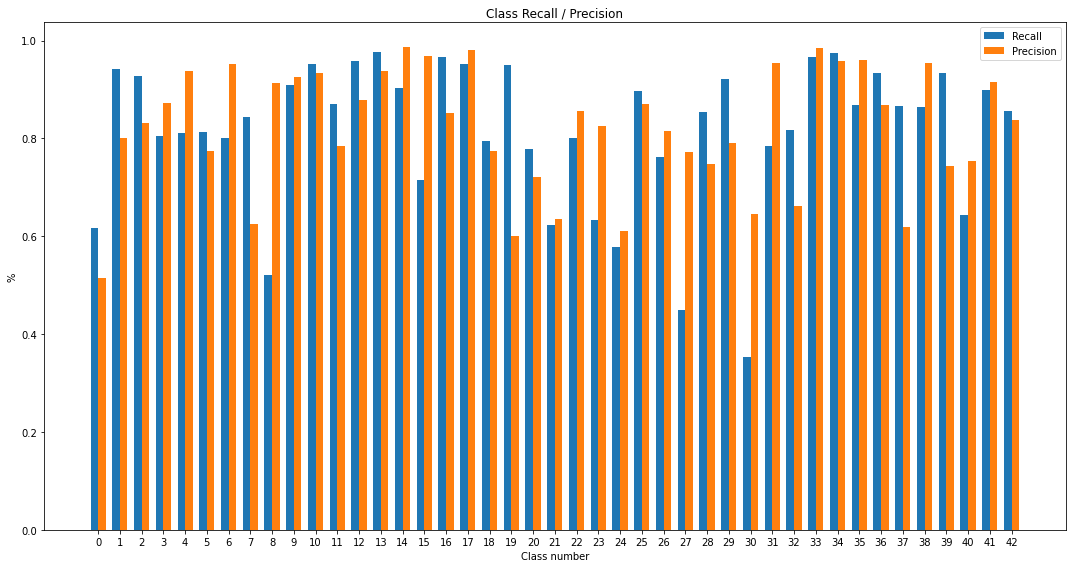

Total accuracy = 0.853


In [51]:
# Evaluating initial over-fit model.
overfit_total_acc, overfit_class_rec, overfit_class_prec = evaluate_model(overfit_CNN, test_images, test_labels)

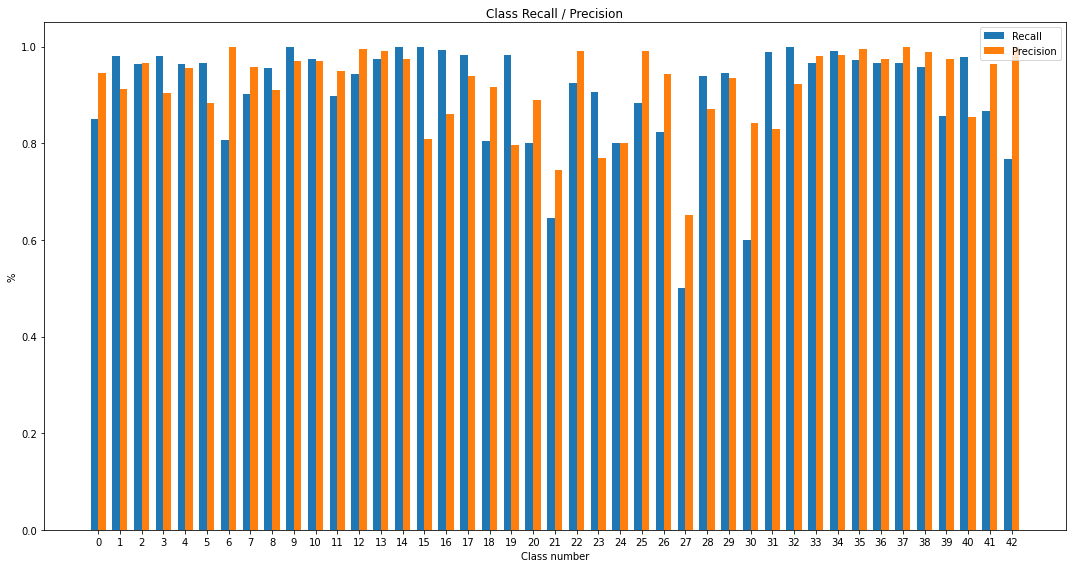

Total accuracy = 0.938


In [52]:
# The final CNN model with hyper parameters tuned.
final_total_acc, final_class_rec, final_class_prec = evaluate_model(final_lenet_5_CNN, test_images, test_labels)

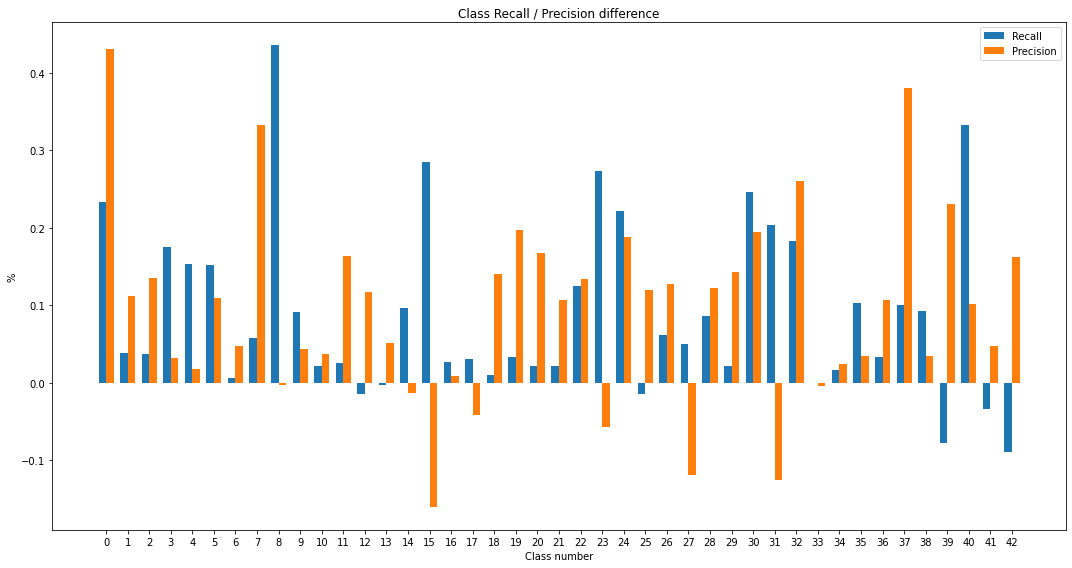

In [63]:
# Display recall and precision difference between the initial overfit and the final models.
rec_difference = final_class_rec - overfit_class_rec # Recall differenece
pre_difference = final_class_prec - overfit_class_prec # Precision difference

classes = np.arange(0,43)
w = 0.35

fig, ax = plt.subplots(figsize=(15,8))
rect_1 = ax.bar(classes - w/2 , rec_difference, width=w, label='Recall')
rect_2 = ax.bar(classes + w/2, pre_difference, width=w, label='Precision')
ax.set_title(f'Class Recall / Precision difference')
ax.set_ylabel('%')
ax.set_xlabel('Class number')
ax.set_xticks(classes)
ax.legend()
fig.tight_layout()
plt.show() 

By tuning the hyper-parameters of the initial overfitting model, the overall accuracy had increased significantly. While the improvements are seen across most of the different classes, some classes resulted in considerably worse performance such as class 15, 17, 23, 27, 31, 39, 41, and 42. Within the training dataset, above classes had smaller data representations than the other classes, which may cause the final network to overlook those classes.  However less represented classes such as 0, 22, 24, 30, 32, 37 and 40 had great improvements in both recall and precision.  

## Conclusion:
By iteratively exploring each hyper-parameter setting, the overall model performance had successfully improved from the initial model. The final model is more generalized than the initial model, however the final model still emits the classification inconsistency given the disproportional class representations in the dataset.
<br>
<br>
The majority of the class recall and precision are around 90%, however, the lowest class recall and precision are as low as 50% and 65% respectively. This is not a sufficient performance considering the application such as deployed in the self-driving car. Additionally, the final model has 685,483 trainable parameters compared to 23,395 trainable parameters for the initial overfitting model, which may cause the longer inference time making it unusable for the time critical applications without a powerful hardware implementation.
<br>
<br>
As per the hardware limitation of the computer used, the hyper-parameter exploration was quite limited. Each hyper-parameter setting is explored alone instead of exploring the combinations of various parameter settings simultaneously which would be capable of exploring larger search space.
<br>
<br>
For further development, producing a dataset with equal data representations might improve the generalization of the model. This can be achieved by augmenting the existing dataset to increase the number of data so that all the classes are proportional in the dataset. 

## References:
[1] Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. Neural Networks32, pp. 323-332, 2012
Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. The German Traffic Sign Recognition Benchmark: A Multi-class Classification Competition. International Joint Conference on Neural Networks (IJCNN 2011), pp. 1453-1460, IEEE Press

[2] Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, doi: 10.1109/5.726791.

[3] Srivastava, N., 2013. Improving neural networks with dropout. University of Toronto, 182(566), p.7.